In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import scipy.io
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

from scipy import stats # to fit linear regression
from math import sqrt

%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.insert(1, '../utilities/')
from helpers import *
from plots import *
from implementations import *
from baselines import *

# Load of training data

The ID indicates both the user and the item : user are identified as "r"+"index" from 1 to 10000, and items as "c"+ "index" from 1 to 1000. The format of the ID are consequently : r index(user) _ c index(item).
The ratings are given as integers from 1 to 5.

We compute them into a matrix with items as row and users as columns. All of the missing ratings are set as 0 and should be predicted to have a valid rating format.

In [3]:
DATA_TRAIN_PATH = '../Datasets/data_train.csv'
ratings = load_data(DATA_TRAIN_PATH)

number of items: 1000, number of users: 10000


In [4]:
ratings.shape

(1000, 10000)

# Exploring the data

### Plot the number of ratings per movie and user

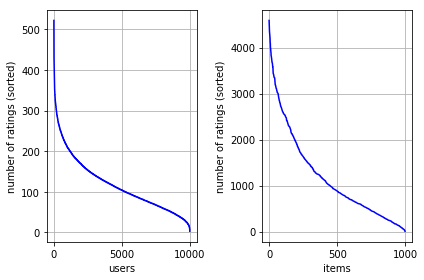

min # of items per user = 3, min # of users per item = 8.


In [6]:
num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

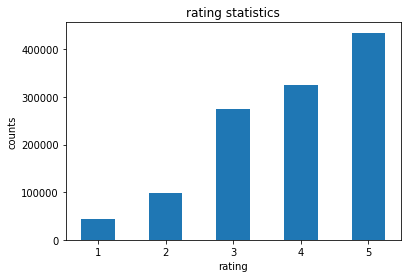

In [7]:
plt.hist(ratings.tocoo().data,np.linspace(0.75,5.25,10))
plt.title("rating statistics")
plt.xlabel("rating")
plt.ylabel("counts")
plt.savefig('../plots/rating_counts.png')

The number of ratings per movie correlates with average its rating.

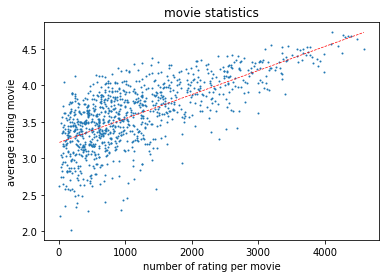

r : 0.6907118956618095, r-squared : 0.4770829228087304


<Figure size 432x288 with 0 Axes>

In [8]:
sum_ratings_movie = np.squeeze(np.asarray(ratings.sum(1)))    # sum of the nonzero elements, for each row
count_ratings_movie = np.diff(ratings.tocsr().indptr)         # count of the nonzero elements, for each row
average_movie_ratings = sum_ratings_movie/count_ratings_movie

plt.scatter(count_ratings_movie,average_movie_ratings,s=1)

plt.title("movie statistics")
plt.xlabel("number of rating per movie")
plt.ylabel("average rating movie")

# To fit linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(count_ratings_movie,average_movie_ratings)

min_count = min(count_ratings_movie)
max_count = max(count_ratings_movie)
plt.plot((min_count,max_count), (min_count*slope + intercept,max_count*slope + intercept),'r',linewidth=0.7
         ,linestyle='dashed')
plt.savefig('../plots/movie_statistics.png')
plt.show()
print("r : {}, r-squared : {}".format(r_value, r_value**2))

On the other hand, the average rating a user gives seems to be relatively unrelated to how many movies he/she rated.

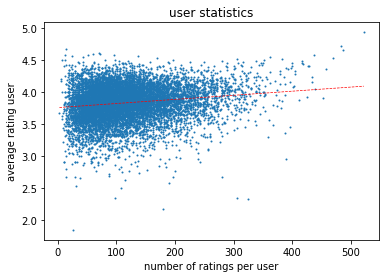

r : 0.15903420258482462, r-squared : 0.025291877591791037


<Figure size 432x288 with 0 Axes>

In [9]:
sum_ratings_user = np.squeeze(np.asarray(ratings.sum(0)))    # sum of the nonzero elements, for each row
count_ratings_user = np.diff(ratings.tocsc().indptr)         # count of the nonzero elements, for each row
average_ratings_user = sum_ratings_user/count_ratings_user
    
plt.scatter(count_ratings_user,average_ratings_user,s=1)
plt.title("user statistics")
plt.xlabel("number of ratings per user")
plt.ylabel("average rating user")

# fit linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(count_ratings_user,average_ratings_user)
min_count = min(count_ratings_user)
max_count = max(count_ratings_user)
plt.plot((min_count,max_count), (min_count*slope + intercept,max_count*slope + intercept),'r',
         linewidth=0.7,linestyle='dashed')

plt.savefig('../plots/user_statistics.png')
plt.show()
print("r : {}, r-squared : {}".format(r_value, r_value**2))

The standard deviations of the user ratings are not particularly telling. Keep in mind that the ratings are discrete which might distort the picture.

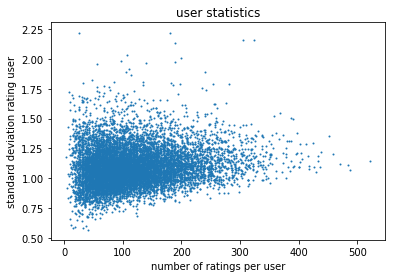

r : 0.14515231272131318, r-squared : 0.021069193888345897


<Figure size 432x288 with 0 Axes>

In [197]:
# calculate the standard deviation of each user's ratings
normalized_ratings = ratings.tocoo()
normalized_ratings.data -= np.mean(normalized_ratings.data)
normalized_ratings.data *= normalized_ratings.data
standard_deviation_user = np.sqrt(np.squeeze(np.asarray((normalized_ratings.sum(0))))/(count_ratings_user-1))

plt.scatter(count_ratings_user,standard_deviation_user,s=1)
plt.title("user statistics")
plt.xlabel("number of ratings per user")
plt.ylabel("standard deviation rating user")

plt.savefig('../plots/SD_user_rating.png')
plt.show()
# fit linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(count_ratings_user,standard_deviation_user)
print("r : {}, r-squared : {}".format(r_value, r_value**2))

# Data analysis

## Data preprocessing - Split the data into a train and test set

Splitting the data into a training and a testing set and removing users and items with fewer than ten values. Those entities contain so little information that stochastic fluctuations might introduce errors in a prediction that accounts for them.

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1059186
Total number of nonzero elements in test data:117687


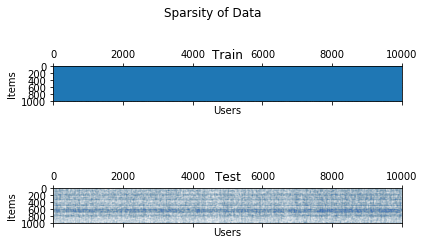

<Figure size 432x288 with 0 Axes>

In [10]:
valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)
plt.savefig("../plots/train_test")

## Standard implementations

### Implementing Baselines 

#### Using the global mean as predictior

In [12]:
print("Global mean baseline predition:\n - train RMSE : {:0.4f}\n - test  RMSE : {:0.4f}"
      .format(baseline_global_mean(train, train),baseline_global_mean(train, test)))

Global mean baseline predition:
 - train RMSE : 1.1193
 - test  RMSE : 1.1168


#### Using the user means as predictors

In [13]:
print("User mean baseline predition:\n - train RMSE : {:0.4f}\n - test  RMSE : {:0.4f}"
      .format(baseline_user_mean(train, train),baseline_user_mean(train, test)))

User mean baseline predition:
 - train RMSE : 1.0846
 - test  RMSE : 1.0943


#### Using the item means as predictors

In [33]:
rmse_item_mean, mean_rating_user = baseline_item_mean(train, test)
print("Item mean baseline predition:\n - train RMSE : {:0.5f}\n - test  RMSE : {:0.5f}"
      .format(sqrt(calculate_mse(train.data,mean_rating_user[train.row])/(train.nnz)),rmse_item_mean))

Item mean baseline predition:
 - train RMSE : 1.02951
 - test  RMSE : 1.02924


#### Using the item mean and the average user offset for a prediction

This baseline prediction uses both the item means and the average user offsets at the same time. To reduce overfitting, averages and offsets of items and users with few rankings were corrected in direction of the global averages of these quantities.

Finding the best blending constant :

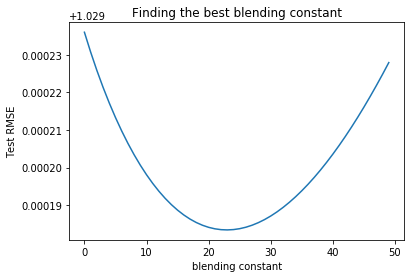

The best blending constant is : 23


<Figure size 432x288 with 0 Axes>

In [11]:
rmse_item_mean_blending = \
    [baseline_item_mean_blending(train, test, blending_constant)[0] for blending_constant in range(50)]
plt.plot(np.arange(50),rmse_item_mean_blending)
plt.title("Finding the best blending constant")
plt.xlabel("blending constant")
plt.ylabel("Test RMSE")

plt.savefig("../plots/blending_constant_item_mean")
plt.show()
best_blending_constant_item_mean = np.argmin(rmse_item_mean_blending)
print("The best blending constant is : {}".format(best_blending_constant_item_mean))

Improved item mean baseline predition:
 - train RMSE : 1.02957
 - test  RMSE : 1.02918


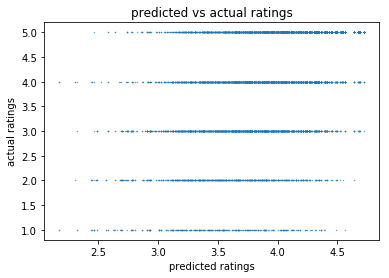

<Figure size 432x288 with 0 Axes>

In [15]:
rmse_item_mean_blending, better_average_movie_ratings = baseline_item_mean_blending(train, test, 
                                                                                    best_blending_constant_item_mean)

print("Improved item mean baseline predition:\n - train RMSE : {:0.5f}\n - test  RMSE : {:0.5f}"
      .format(sqrt(calculate_mse(train.data,better_average_movie_ratings[train.row])/(train.nnz)),
              rmse_item_mean_blending))

# Plot prediction versus test values
plt.title("predicted vs actual ratings")
plt.xlabel("predicted ratings")
plt.ylabel("actual ratings")
plt.scatter(better_average_movie_ratings[test.row][:10000], test.data[:10000],s=0.1)

plt.savefig("../plots/item_mean_pred")
plt.show()

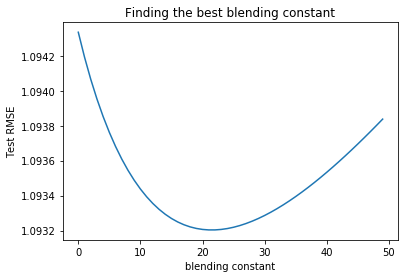

The best blending constant is : 21


<Figure size 432x288 with 0 Axes>

In [16]:
# find the best blending constant
rmse_user_offset_blending = \
    [baseline_user_offset_blending(train, test, blending_constant)[0] for blending_constant in range(50)]
plt.plot(np.arange(50),rmse_user_offset_blending)
plt.title("Finding the best blending constant")
plt.xlabel("blending constant")
plt.ylabel("Test RMSE")

plt.savefig("../plots/blending_constant_user_offset")
plt.show()
best_blending_constant_user_offset = np.argmin(rmse_user_offset_blending)
print("The best blending constant is : {}".format(best_blending_constant_user_offset))

User offset baseline predition:
 - train RMSE : 1.08567
 - test  RMSE : 1.09320


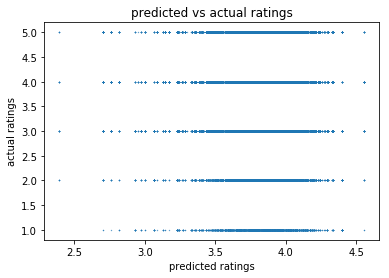

<Figure size 432x288 with 0 Axes>

In [28]:
rmse_user_offset_blending, better_average_user_offsets = baseline_user_offset_blending(train, test, 21)

print("User offset baseline predition:\n - train RMSE : {:0.5f}\n - test  RMSE : {:0.5f}"
      .format(sqrt(calculate_mse(train.data,better_average_user_offsets[train.col]+np.mean(train.data))/(train.nnz)),
              rmse_user_offset_blending))

# Plot prediction versus test values
plt.title("predicted vs actual ratings")
plt.xlabel("predicted ratings")
plt.ylabel("actual ratings")
plt.scatter(better_average_user_offsets[test.row]+np.mean(train.data), test.data,s=0.1)

plt.savefig("../plots/user_offset_pred")
plt.show()

Combining improved item mean and user offset predictions:

In [19]:
rmse_average_item_user_offset, better_average_movie_ratings, better_average_user_offsets = \
    baseline_average_item_user_offset(train, test, 23, 21)

prediction_train = better_average_movie_ratings[train.row] + better_average_user_offsets[train.col]


print("User offset/Item mean baseline predition:\n - train RMSE : {:0.5f}\n - test  RMSE : {:0.5f}"
      .format(sqrt(calculate_mse(train.data, prediction_train)/(train.nnz)),
              rmse_average_item_user_offset))

# Clipping predictions above 5 and below 1.

prediction_train[prediction_train > 5] = 5;
prediction_train[prediction_train < 1] = 1;
prediction_test = better_average_movie_ratings[test.row] + better_average_user_offsets[test.col]
prediction_test[prediction_test > 5] = 5;
prediction_test[prediction_test < 1] = 1;
print("Clipped user offset/Item mean baseline predition:\n - train RMSE : {:0.5f}\n - test  RMSE : {:0.5f}"
      .format(sqrt(calculate_mse(train.data, prediction_train)/(train.nnz)),
              sqrt(calculate_mse(test.data, prediction_test)/(test.nnz))))

User offset/Item mean baseline predition:
 - train RMSE : 0.99546
 - test  RMSE : 1.00409
Clipped user offset/Item mean baseline predition:
 - train RMSE : 0.99544
 - test  RMSE : 1.00406


#### Use both user and item indices for linear prediction

For this last baseline prediction, a simple linear model was chosen to be : $y_{pred}[d,n] ≈ w_0 + w_{item}[d] + w_{user}[n]$ , with (D+N+1) parameters. Minimizing the (R)MSE (by setting the gradient of the loss function with respect to the weights to zero) results in a system of linear equations that can be solved.

User offset average item baseline predition:
 - train RMSE : 0.98917
 - test  RMSE : 1.00025


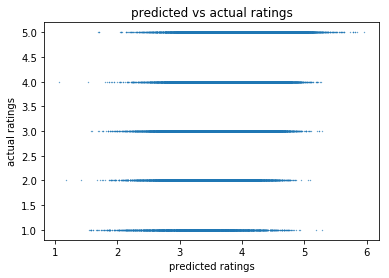

<Figure size 432x288 with 0 Axes>

In [19]:
rmse_te, w_item, w_user, w_0 = baseline_item_user(train, test)

prediction_train = w_item[train.row] + w_user[train.col] + w_0
print("User offset average item baseline predition:\n - train RMSE : {:0.5f}\n - test  RMSE : {:0.5f}"
      .format(sqrt(calculate_mse(train.data, prediction_train)/(train.nnz)),
              rmse_te))

# Plot prediction versus test values
plt.title("predicted vs actual ratings")
plt.xlabel("predicted ratings")
plt.ylabel("actual ratings")
plt.scatter(w_item[test.row] + w_user[test.col] + w_0, test.data,s=0.1)

plt.savefig("../plots/baseline_linear_pred")
plt.show()

## Matrix Factorization

The implemented baselines do not account for any interaction in the relation between movies and user. That is, the previous models neglect if one user has a particular affinity for action movies and not for romantic comedies. If one were to just generalize the linear model from above to $y_{pred}[d,n] = w_0 + w_{item}[d] + w_{user}[n] + w_{item,user}[n,d]$ , the model would comprise ($1+D+N+D\times N$) parameters - too many to be useful. In order to introduce interaction terms with fewer variables, we use matrix factorization.

### Learn the Matrix Factorization using SGD

#### Matrix factorization SGD basic

In [20]:
matrix_factorization_SGD(train, test)

learn the matrix factorization using SGD...
initial RMSE on training set: 1.3071287373574476, RMSE on testing set: 1.3052388688004901.
RMSE on test data: 1.079742526743619.


#### Matrix factorization SGD regularized

The basic version of the matrix factorizarion implemented above is prone to overfitting; the training error decreases progressively but the test error doesn't follow. Therefore ridge the ridge terms $\lambda_{item}$ and $\lambda_{user}$ are introduced to limit the growth of the weights in the matrices that factorize the data.

In [22]:
# define parameters 
num_features = 40   # K in the lecture notes

lambda_user = 0.08
lambda_item = 0.08
    
gamma = 0.05
gamma_dec_step_size = 1.2
num_epochs = 15     # number of full passes through the train set
stop_criterion = 1e-4
    
seed = 988

matrix_factorization_SGD_regularized(train, test, num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size, 
                                     num_epochs, seed, stop_criterion)


learn the matrix factorization using SGD...
initial RMSE on training set: 1.2390613923769698, RMSE on testing set: 1.2372345918205176.
iter: 0, RMSE on training set: 1.0588242461230786, RMSE on testing set: 1.0773640743570123.
iter: 1, RMSE on training set: 1.038409837365067, RMSE on testing set: 1.0604153282512494.
iter: 2, RMSE on training set: 1.0262790658245189, RMSE on testing set: 1.0491782269277674.
iter: 3, RMSE on training set: 1.0158464414628225, RMSE on testing set: 1.0443800488180899.
iter: 4, RMSE on training set: 0.9978089982393074, RMSE on testing set: 1.0302138915846641.
iter: 5, RMSE on training set: 0.9826293271784594, RMSE on testing set: 1.0202782787630051.
iter: 6, RMSE on training set: 0.9700711337597688, RMSE on testing set: 1.012251534794236.
iter: 7, RMSE on training set: 0.9637524449439893, RMSE on testing set: 1.0092944182583956.
iter: 8, RMSE on training set: 0.956877617856096, RMSE on testing set: 1.0052946028335745.
iter: 9, RMSE on training set: 0.9508067

0.992832495004245

##### Tuning Hyperparameters - gamma & decrement

Therefore three parameters need to be tuned, namely, the ridge terms $\lambda_{item}$ and $\lambda_{user}$ and the number of features $K$ for the matrix factorization. In addition, the learning rate $\gamma$ and the rate of its decrease $\delta_\gamma$ have an impact on the minimal error that can be optained as well. It would require a lot of computational power to probe possile values for all those variables systematically.

As a first step, for fixed $\lambda_{item}$, $\lambda_{user}$ and $K$, a grid search was performed to find $\gamma$ and $\delta_\gamma$ minimizing the error. As these computations take already fairly long, the corresponding code is comented and the resulting error can be loaded from a separate file in the cell just below.

In [34]:
"""
# define parameters 
num_features = 25   # K in the lecture notes

lambda_user = 0.08
lambda_item = 0.08
    
gammas = np.logspace(-2,-1,num = 5)
gamma_dec_step_sizes = np.linspace(1.1,1.3,5)


num_epochs = 30     # number of full passes through the train set
stop_criterion = 1e-4
    
seeds = np.array([988,1000])
#seeds = np.array([988])

rmse_te = np.zeros((len(seeds),len(gammas),len(gamma_dec_step_sizes)))

for ind_seed, seed in enumerate(seeds):
    for ind_gamma, gamma in enumerate(gammas):
        for ind_gamma_dec_step_size, gamma_dec_step_size in enumerate(gamma_dec_step_sizes):
            print("seed ({}/{}) = {}".format(ind_seed+1, len(seeds), seed))
            print("gamma ({}/{}) = {}".format(ind_gamma+1, len(gammas), gamma))
            print("stepsize decrement ({}/{}) = {}".format(ind_gamma_dec_step_size+1, len(gamma_dec_step_sizes), 
                                                           gamma_dec_step_size))
            
            rmse_te[ind_seed,ind_gamma,ind_gamma_dec_step_size] = \
                matrix_factorization_SGD_regularized(train, test, num_features, lambda_user, lambda_item, gamma,
                                                     gamma_dec_step_size, num_epochs, seed, stop_criterion)

np.save('../results_of_lengthy_computations/RMSE_test_tuning_gammas',rmse_te)
"""

'\n# define parameters \nnum_features = 25   # K in the lecture notes\n\nlambda_user = 0.08\nlambda_item = 0.08\n    \ngammas = np.logspace(-2,-1,num = 5)\ngamma_dec_step_sizes = np.linspace(1.1,1.3,5)\n\n\nnum_epochs = 30     # number of full passes through the train set\nstop_criterion = 1e-4\n    \nseeds = np.array([988,1000])\n#seeds = np.array([988])\n\nrmse_te = np.zeros((len(seeds),len(gammas),len(gamma_dec_step_sizes)))\n\nfor ind_seed, seed in enumerate(seeds):\n    for ind_gamma, gamma in enumerate(gammas):\n        for ind_gamma_dec_step_size, gamma_dec_step_size in enumerate(gamma_dec_step_sizes):\n            print("seed ({}/{}) = {}".format(ind_seed+1, len(seeds), seed))\n            print("gamma ({}/{}) = {}".format(ind_gamma+1, len(gammas), gamma))\n            print("stepsize decrement ({}/{}) = {}".format(ind_gamma_dec_step_size+1, len(gamma_dec_step_sizes), gamma_dec_step_size))\n            \n            rmse_te[ind_seed,ind_gamma,ind_gamma_dec_step_size] = matrix_f

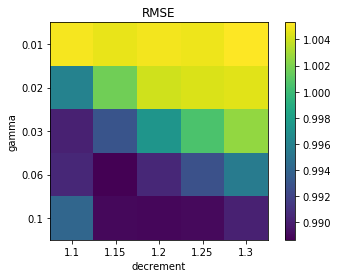

<Figure size 432x288 with 0 Axes>

In [23]:
RMSE_test_tuning_gammas = np.load('../results_of_lengthy_computations/RMSE_test_tuning_gammas.npy')
gammas = np.logspace(-2,-1,num = 5)
gamma_dec_step_sizes = np.linspace(1.1,1.3,5)
plot_simple_heatmap(np.min(RMSE_test_tuning_gammas, axis = 0), "RMSE", "decrement", np.around(gamma_dec_step_sizes,2),
                    "gamma",np.around(gammas,2))
plt.savefig('../plots/heatmap_tuning_gammas.png')

For $\lambda_{item} = \lambda_{user} = 0.08 $ and $K = 25$, the parameters minimizing the errors are:

In [24]:
argmin_over_gammas = np.argmin(np.min(RMSE_test_tuning_gammas, axis = 0), axis = 0)
argmin_global = \
np.argmin(np.min(RMSE_test_tuning_gammas, axis = 0)[argmin_over_gammas,np.arange(len(gamma_dec_step_sizes))], axis = 0)
gamma_dec_star = gamma_dec_step_sizes[argmin_global]
gamma_star = gammas[argmin_over_gammas[argmin_global]]
print("The decrement step is : {dec:1.2f} and the best gamma is {g:0.3f}".format(dec = gamma_dec_star,g = gamma_star))
print("The corresponding error is : {err:1.4f}".format(err = np.min(np.min(RMSE_test_tuning_gammas, axis = 0))))

The decrement step is : 1.15 and the best gamma is 0.056
The corresponding error is : 0.9886


### Learn the Matrix Factorization using Alternating Least Squares

An alternative algorithm performing the matrix factorization is ALS.

For $\lambda_{item} = \lambda_{user} = 0.08 $ and $K = 25$, the RMSE from ALS is just a little smaller than it was with SGD ($\gamma$ and $\delta_\gamma$ optimized by grid search) for the same parameters.

In [26]:
# define parameters
num_features = 25   # K in the lecture notes
lambda_user = 0.08
lambda_item = 0.08
stop_criterion = 1e-3
max_iter = 20

seeds = 988

ALS(train, test, num_features, lambda_user, lambda_item, max_iter, seed, stop_criterion)

initial: RMSE on training set: 1.3071287373574476, RMSE on testing set: 1.3052388688004901.
iter: 0, RMSE on training set: 0.9519054032723246, RMSE on testing set: 1.017714471190868.
iter: 1, RMSE on training set: 0.9315802604917478, RMSE on testing set: 1.003362815799362.
iter: 2, RMSE on training set: 0.9100196143174027, RMSE on testing set: 0.9968938521418712.
iter: 3, RMSE on training set: 0.8978135873998376, RMSE on testing set: 0.9935087567550255.
iter: 4, RMSE on training set: 0.8908915580800574, RMSE on testing set: 0.9917070102761273.
iter: 5, RMSE on training set: 0.8865317019111828, RMSE on testing set: 0.9905511255013821.
iter: 6, RMSE on training set: 0.8836344304523723, RMSE on testing set: 0.9897784422755475.
iter: 7, RMSE on training set: 0.8816238424159367, RMSE on testing set: 0.9892569669449173.
iter: 8, RMSE on training set: 0.8801742015688895, RMSE on testing set: 0.9888997474217414.
iter: 9, RMSE on training set: 0.8790928220247602, RMSE on testing set: 0.98864780

0.9875232564928758

##### Tuning Hyperparameters - lambda user & lambda item

ALS comes with the advantage that one doesn't need to worry about the learning rate and how it decreases. The only parameters to tune are the ridge terms and the number of features. However, a major downside of ALS for parameter tuning is that it takes longer to run.

Again the first approach was to run a grid search. This time, $\lambda_{item}$ and $\lambda_{user} $ were varied and $K$ was again kept constant. As the computations are long, the corresponding cell is commented and the result can be loaded from a separate file just below.

In [ ]:
"""
# define parameters 
num_features = 25   # K in the lecture notes
lambda_users = np.logspace(-2,0,num = 5)
lambda_items = np.logspace(-2,0,num = 5)
stop_criterion = 1e-4
max_iter = 15
    
seeds = np.array([988])

rmse_te = np.zeros((len(seeds),len(lambda_users),len(lambda_items)))

for ind_seed, seed in enumerate(seeds):
    for ind_lambda_user, lambda_user in enumerate(lambda_users):
        for ind_lambda_item, lambda_item in enumerate(lambda_items):
            print("seed ({}/{}) = {}".format(ind_seed+1, len(seeds), seed))
            print("lambda_user ({}/{}) = {}".format(ind_lambda_user+1, len(lambda_users), lambda_user))
            print("lambda_item ({}/{}) = {}".format(ind_lambda_item+1, len(lambda_items), lambda_item))
            
            rmse_te[ind_seed,ind_lambda_user,ind_lambda_item] = ALS(train, test, num_features, lambda_user, 
                                                                    lambda_item, max_iter, seed, stop_criterion)

np.save('../results_of_lengthy_computations/RMSE_test_tuning_lambdas',rmse_te)
"""

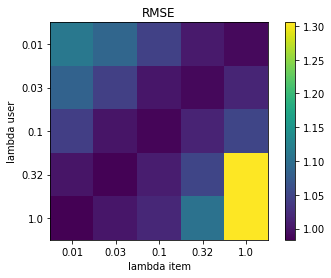

<Figure size 432x288 with 0 Axes>

In [29]:
RMSE_test_tuning_lambdas = np.load('../results_of_lengthy_computations/RMSE_test_tuning_lambdas.npy')
lambda_users = np.logspace(-2,0,num = 5)
lambda_items = np.logspace(-2,0,num = 5)
plot_simple_heatmap(RMSE_test_tuning_lambdas, "RMSE", "lambda item",np.around(lambda_items,2), "lambda user",
                    np.around(lambda_users,2))
plt.savefig('../plots/heatmap_tuning_lambdas.png')

It seems as if the value of product of $\lambda_{item}$ and $\lambda_{user} $ was relevant for obtaining the lowest RMSEs. Intuitively, this seems plausible, as the product of two matrices gets calculated. If the values in one matrix are strongly penalized to be reduced by a factor, the same predictions can still be obtained by making all the values in the other matrix bigger by the same factor.

In [30]:
argmin_over_lambda_users = np.argmin(RMSE_test_tuning_lambdas, axis = 0)
argmin_global = np.argmin(RMSE_test_tuning_lambdas[argmin_over_lambda_users,np.arange(len(lambda_items))], axis = 0)
lambda_item_star = lambda_items[argmin_global]
lambda_user_star = lambda_users[argmin_over_lambda_users[argmin_global]]
print("The best lambda item is : {} and the best lambda user is {}".format(lambda_item_star,lambda_user_star))
print("The corresponding error is : {err:1.4f}".format(err = np.min(RMSE_test_tuning_lambdas)))

The best lambda item is : 0.01 and the best lambda user is 1.0
The corresponding error is : 0.9833


### Prediction SGD & ALS with tuned parameters

If one assumes that the same $\gamma$ and $\delta_\gamma$ are optimal for SGD independent of $\lambda_{item}$ and $\lambda_{user} $, one can compare the predictions of ALS and SGD with tuned parameters.

In [31]:
# define parameters 
num_features = 25   # K in the lecture notes    
seed = 988
num_epochs = 15     # number of full passes through the train set
stop_criterion = 1e-4
max_iter = 15

min_rmse_te_SGD, best_user_features_SGD, best_item_features_SGD = matrix_factorization_SGD_regularized_predict(train,
                                                                           test, num_features, lambda_user_star, 
                                                                           lambda_item_star, gamma_star, gamma_dec_star, 
                                                                           num_epochs, seed, stop_criterion)
min_rmse_te_ALS, best_user_features_ALS, best_item_features_ALS = ALS_pred(train, test, num_features, lambda_user_star,
                                                                           lambda_item_star, max_iter, seed, 
                                                                           stop_criterion)


learn the matrix factorization using SGD...
initial RMSE on training set: 1.3071287373574476, RMSE on testing set: 1.3052388688004901.
iter: 0, RMSE on training set: 1.2804128112146969, RMSE on testing set: 1.2921882934989557.
iter: 1, RMSE on training set: 1.2598715055806557, RMSE on testing set: 1.2676771007912275.
iter: 2, RMSE on training set: 1.2293768943084653, RMSE on testing set: 1.239354113046117.
iter: 3, RMSE on training set: 1.2099015935248405, RMSE on testing set: 1.22021148531272.
iter: 4, RMSE on training set: 1.1836584111807802, RMSE on testing set: 1.1933089853575036.
iter: 5, RMSE on training set: 1.1620249236228821, RMSE on testing set: 1.1754710208848675.
iter: 6, RMSE on training set: 1.1314273548378626, RMSE on testing set: 1.1466186110869152.
iter: 7, RMSE on training set: 1.1164371151679229, RMSE on testing set: 1.1331662983835737.
iter: 8, RMSE on training set: 1.0987146648443278, RMSE on testing set: 1.1142508172309138.
iter: 9, RMSE on training set: 1.0835417

This assumption, however, does not seem to be valid.

# SGD with baseline correction

The matrix factorization as implemented above does not explicily contain any component that depends only on the user or only on the movie. Here we consider the matrix factorization to model the interaction terms $w_{item,user}[n,d]$ of the linear model mentioned previously and that was useless because it contained too many parameters. The model then becomes $y_{pred}[d,n] = w_0 + w_{item}[d] + w_{user}[n] + w_{item,user}[n,d]$. Any of the baseline predictions above can be written in the form $w_0 + w_{item}[d] + w_{user}[n]$. The easiest way to implement this model is to substract a baseline prediction from the train matrix and let the matrix factorization learn on the error of the baseline prediction.

One advantage is that the mean of the errors made by the baseline prediction is zero. If one introduces ridge terms one does not necessarily penalize terms contributing to high predictions disproportionally anymore. However, the matrices that factorize the data must be initialized differently.

#### baseline item mean

Already when just the item mean is substracted and the parameters are tuned by trial and error, the prediction gets better than ALS with tuned parameters.

In [34]:
num_features = 25   # K in the lecture notes
lambda_user = 0.15
lambda_item = 0.02
stop_criterion = 0
num_epochs = 15
seed = 988

gamma = 0.2
gamma_dec_step_size = 1.25

# Substract baseline from train and test
train_baseline_corrected = sp.coo_matrix((train.data - mean_rating_user[train.row], (train.row, train.col)), 
                                         shape=train.get_shape())
test_baseline_corrected = sp.coo_matrix((test.data - mean_rating_user[test.row], (test.row, test.col)), 
                                        shape=test.get_shape())
# Matrix factorization on baseline corrected data
min_rmse_te_SGD_bc, user_features_SGD_bc, item_features_SGD_bc = \
    matrix_factorization_SGD_regularized_predict(train_baseline_corrected, test_baseline_corrected, num_features, 
                                                 lambda_user, lambda_item, gamma, gamma_dec_step_size, num_epochs, 
                                                 seed, stop_criterion, True)

learn the matrix factorization using SGD...
initial RMSE on training set: 1.029510536238281, RMSE on testing set: 1.029236033758104.
iter: 0, RMSE on training set: 1.0013790973671624, RMSE on testing set: 1.0332596839269024.
iter: 1, RMSE on training set: 0.9747633112876449, RMSE on testing set: 1.0239792084905683.
iter: 2, RMSE on training set: 0.9410131219406648, RMSE on testing set: 1.012337429239786.
iter: 3, RMSE on training set: 0.9162889788515982, RMSE on testing set: 1.003900516579653.
iter: 4, RMSE on training set: 0.8981309154582594, RMSE on testing set: 1.001399143594171.
iter: 5, RMSE on training set: 0.8841788277659749, RMSE on testing set: 0.9978978677946252.
iter: 6, RMSE on training set: 0.8736079798070456, RMSE on testing set: 0.9970940869386263.
iter: 7, RMSE on training set: 0.8652022265973549, RMSE on testing set: 0.99654557507751.
iter: 8, RMSE on training set: 0.8592814046008409, RMSE on testing set: 0.9964819319989704.
iter: 9, RMSE on training set: 0.85404754231

But still if the predicted baeline error is plotted against the actual one, the relationship is only approximately linear.

0.9964819319989704


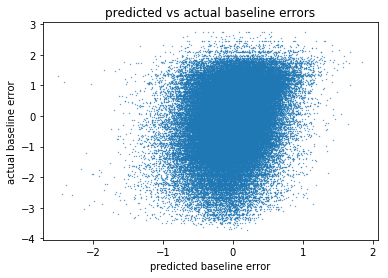

<Figure size 432x288 with 0 Axes>

In [35]:
print(compute_error(test_baseline_corrected.data, user_features_SGD_bc, item_features_SGD_bc, (test.row,test.col)))
# Plot prediction versus test values
plt.title("predicted vs actual baseline errors")
plt.xlabel("predicted baseline error")
plt.ylabel("actual baseline error")
plt.scatter(np.dot(item_features_SGD_bc.T,user_features_SGD_bc)[test.nonzero()], test_baseline_corrected.data,s=0.1)

plt.savefig('../plots/item_mean_baseline_pred_err.png')
plt.show()

In [36]:
approx_data_matrix = np.dot(item_features_SGD_bc.T,user_features_SGD_bc)
data_pred = approx_data_matrix[(test.row,test.col)]+mean_rating_user[test.row]
data_pred[data_pred > 5] = 5
data_pred[data_pred < 1] = 1
sqrt(calculate_mse(test.data,data_pred)/(len(test.data)))

0.9964503201435831

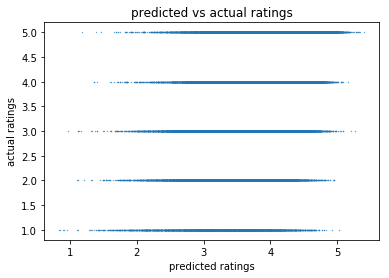

<Figure size 432x288 with 0 Axes>

In [37]:
# Plot prediction versus test values
plt.title("predicted vs actual ratings")
plt.xlabel("predicted ratings")
plt.ylabel("actual ratings")
plt.scatter(np.dot(item_features_SGD_bc.T,user_features_SGD_bc)[test.nonzero()]+mean_rating_user[test.row], 
            test.data,s=0.1)

plt.savefig('../plots/item_mean_baseline_pred.png')
plt.show()

#### baseline item mean, average user offset, blending

The error gets slightly lower if a better baseline prediction is used and the parameters are tuned by trial and error.

In [38]:
num_features = 100   # K in the lecture notes
lambda_user = 0.15
lambda_item = 0.03
stop_criterion = 0
max_iter = 10
num_epochs = 20
seed = 988

gamma = 0.08
gamma_dec_step_size = 1.15

train_baseline_pred = better_average_movie_ratings[train.row] + better_average_user_offsets[train.col]
test_baseline_pred = better_average_movie_ratings[test.row] + better_average_user_offsets[test.col]

train_baseline_corrected = sp.coo_matrix((train.data - train_baseline_pred, (train.row, train.col)), 
                                         shape=train.get_shape())
test_baseline_corrected = sp.coo_matrix((test.data - test_baseline_pred, (test.row, test.col)), 
                                        shape=test.get_shape())

min_rmse_te_SGD_bc, user_features_SGD_bc, item_features_SGD_bc = \
    matrix_factorization_SGD_regularized_predict(train_baseline_corrected, test_baseline_corrected, num_features, 
                                                 lambda_user, lambda_item, gamma, gamma_dec_step_size, num_epochs, 
                                                 seed, stop_criterion,True)

learn the matrix factorization using SGD...
initial RMSE on training set: 0.9953396229471951, RMSE on testing set: 1.0041073388816242.
iter: 0, RMSE on training set: 0.9952791953920906, RMSE on testing set: 1.0040821857750646.
iter: 1, RMSE on training set: 0.9907851544161971, RMSE on testing set: 1.000986766932696.
iter: 2, RMSE on training set: 0.9780305997433196, RMSE on testing set: 0.9940575568997516.
iter: 3, RMSE on training set: 0.9681018271792556, RMSE on testing set: 0.9903789675301814.
iter: 4, RMSE on training set: 0.9549902724671315, RMSE on testing set: 0.9868889321662243.
iter: 5, RMSE on training set: 0.9393809028923884, RMSE on testing set: 0.9844584468384996.
iter: 6, RMSE on training set: 0.9221246829448799, RMSE on testing set: 0.9829812963690747.
iter: 7, RMSE on training set: 0.9035467379683598, RMSE on testing set: 0.9821858427974629.
iter: 8, RMSE on training set: 0.8855701582817419, RMSE on testing set: 0.982599707434798.
iter: 9, RMSE on training set: 0.869073

0.9821858427974629


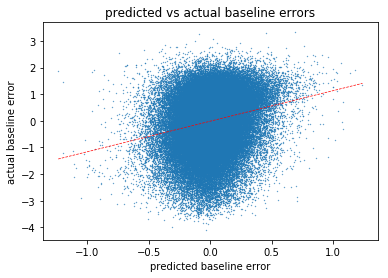

r : 0.20988401600098078, r-squared : 0.04405130017269995


<Figure size 432x288 with 0 Axes>

In [39]:
print(compute_error(test_baseline_corrected.data, user_features_SGD_bc, item_features_SGD_bc, (test.row,test.col)))
# Plot prediction versus test values
plt.title("predicted vs actual baseline errors")
plt.xlabel("predicted baseline error")
plt.ylabel("actual baseline error")
plt.scatter(np.dot(item_features_SGD_bc.T,user_features_SGD_bc)[test.nonzero()], test_baseline_corrected.data,s=0.1)
# fit linear regression
slope, intercept, r_value, p_value, std_err = \
    scipy.stats.linregress(np.dot(item_features_SGD_bc.T,user_features_SGD_bc)[test.nonzero()],
                           test_baseline_corrected.data)
min_count = min(np.dot(item_features_SGD_bc.T,user_features_SGD_bc)[test.nonzero()])
max_count = max(np.dot(item_features_SGD_bc.T,user_features_SGD_bc)[test.nonzero()])
plt.plot((min_count,max_count), (min_count*slope + intercept,max_count*slope + intercept),
         'r',linewidth=0.7,linestyle='dashed')
plt.savefig('../plots/item_mean_av_offset_baseline_pred.png')
plt.show()

print("r : {}, r-squared : {}".format(r_value, r_value**2))

# Parameter tuning by gradient descent

One of the major challenges that remains is to tune the parameters effieciently. It is not feasible to tune all the parameters at once by grid search, as it leads to a combinatorial explosion even with few parameter to tune. Instead, gradient descent in the parameter space was implemented. One parameter at a time is therefore varied slightly and the change in the error determined by SGD. From this, the gradient of the loss function in the parameter space is approximated and a small step in the opposite direction is executed. This procedure gets applied iteratively. Still, the computations are long and therefore the code is commented and the result is saved below.

### Simple Matrix factorization by SGD

The best parameters combination from the grid search was taken as the initial condition. Note that $K$ has not been varied previously. Therefore it is the variable that undergoes the most signifcant change.

In [349]:
"""
seed = 988
stop_criterion = 0
lr = 0.005 # learning rate for gradient descent in the parameter space
dec_lr = 1.2 # decrement of the learning rate
dx = 0.0005 # stepsize for gradient approximation
max_iter = 15 # iterations of the global loop
num_epochs = 20 # epochs of SGD


# Initial values of parameters
num_features_init = 25   # K in the lecture notes
lambda_user_init = 0.08
lambda_item_init = 0.08
gamma_init = 0.056
gamma_dec_step_size_init = 1.15

min_rmse_te, num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size = \
    gradient_descent_tuning_parameters_MF_SGD(train, test, num_features_init, 
                                              lambda_user_init, lambda_item_init, gamma_init, gamma_dec_step_size_init, 
                                              seed, stop_criterion, lr, dec_lr, dx, max_iter, num_epochs, False)
"""

learn the matrix factorization using SGD...
initial RMSE on training set: 1.3071287373574476, RMSE on testing set: 1.3052388688004901.
iter: 0, RMSE on training set: 1.0886692103715816, RMSE on testing set: 1.1044693226859987.
iter: 1, RMSE on training set: 1.0690533739828252, RMSE on testing set: 1.084872008022357.
iter: 2, RMSE on training set: 1.053757227822079, RMSE on testing set: 1.0744695347889504.
iter: 3, RMSE on training set: 1.0336222942927118, RMSE on testing set: 1.0560395637399942.
iter: 4, RMSE on training set: 1.0187044904950446, RMSE on testing set: 1.0450392237609942.
iter: 5, RMSE on training set: 1.0046823766347326, RMSE on testing set: 1.0353164978816336.
iter: 6, RMSE on training set: 0.9891868989127227, RMSE on testing set: 1.0250914820761017.
iter: 7, RMSE on training set: 0.9825728592545956, RMSE on testing set: 1.0223277744969395.
iter: 8, RMSE on training set: 0.971296146213164, RMSE on testing set: 1.013833604089881.
iter: 9, RMSE on training set: 0.96234028

iter: 0, RMSE on training set: 1.0897343244693256, RMSE on testing set: 1.1055186464311801.
iter: 1, RMSE on training set: 1.0699365774941405, RMSE on testing set: 1.0857450421467396.
iter: 2, RMSE on training set: 1.0543605451585794, RMSE on testing set: 1.0751160631713648.
iter: 3, RMSE on training set: 1.0340073334095368, RMSE on testing set: 1.0565082977610432.
iter: 4, RMSE on training set: 1.0190021249558034, RMSE on testing set: 1.0454548877270795.
iter: 5, RMSE on training set: 1.0048432873141404, RMSE on testing set: 1.0356230359571998.
iter: 6, RMSE on training set: 0.9892311400857926, RMSE on testing set: 1.0253241241797773.
iter: 7, RMSE on training set: 0.9825707374145243, RMSE on testing set: 1.0225527934024554.
iter: 8, RMSE on training set: 0.9712148565980907, RMSE on testing set: 1.0140025802719135.
iter: 9, RMSE on training set: 0.9621795806310462, RMSE on testing set: 1.007987694598186.
iter: 10, RMSE on training set: 0.9563395460448153, RMSE on testing set: 1.005600

iter: 0, RMSE on training set: 1.0959023539660318, RMSE on testing set: 1.1086068296015321.
iter: 1, RMSE on training set: 1.0715061336266298, RMSE on testing set: 1.0861157146335894.
iter: 2, RMSE on training set: 1.0546379292373749, RMSE on testing set: 1.0710897927826715.
iter: 3, RMSE on training set: 1.0396628830320396, RMSE on testing set: 1.0602967487744663.
iter: 4, RMSE on training set: 1.025388985638465, RMSE on testing set: 1.0482544680463908.
iter: 5, RMSE on training set: 1.0098572158151153, RMSE on testing set: 1.0358206833239303.
iter: 6, RMSE on training set: 0.9981124184794411, RMSE on testing set: 1.0282209955203117.
iter: 7, RMSE on training set: 0.9891418287809609, RMSE on testing set: 1.0191256253343726.
iter: 8, RMSE on training set: 0.982046674513775, RMSE on testing set: 1.0174996997196302.
iter: 9, RMSE on training set: 0.9734453694667258, RMSE on testing set: 1.0113272227648222.
iter: 10, RMSE on training set: 0.9698202216927961, RMSE on testing set: 1.0089451

iter: 2, RMSE on training set: 1.0576611687834196, RMSE on testing set: 1.078639658572462.
iter: 3, RMSE on training set: 1.0343533638989502, RMSE on testing set: 1.0551706520400361.
iter: 4, RMSE on training set: 1.021418706125425, RMSE on testing set: 1.0474497864272754.
iter: 5, RMSE on training set: 1.0053391520033765, RMSE on testing set: 1.0359098406088074.
iter: 6, RMSE on training set: 0.9939673673057032, RMSE on testing set: 1.028288866463289.
iter: 7, RMSE on training set: 0.9816134497948422, RMSE on testing set: 1.0220297839473345.
iter: 8, RMSE on training set: 0.9738837361398003, RMSE on testing set: 1.0164402942944004.
iter: 9, RMSE on training set: 0.9634600176735095, RMSE on testing set: 1.0088981349355455.
iter: 10, RMSE on training set: 0.9581816951953794, RMSE on testing set: 1.006502812745035.
iter: 11, RMSE on training set: 0.9521723198446166, RMSE on testing set: 1.0026039582299364.
iter: 12, RMSE on training set: 0.9467564780755908, RMSE on testing set: 0.9997154

iter: 2, RMSE on training set: 1.0581133709897736, RMSE on testing set: 1.079124046960874.
iter: 3, RMSE on training set: 1.0346193371440833, RMSE on testing set: 1.0554906387999035.
iter: 4, RMSE on training set: 1.0216312491538866, RMSE on testing set: 1.0477387925979775.
iter: 5, RMSE on training set: 1.0054645047963409, RMSE on testing set: 1.036140380455418.
iter: 6, RMSE on training set: 0.9940271990034875, RMSE on testing set: 1.028473674104845.
iter: 7, RMSE on training set: 0.9816034403376508, RMSE on testing set: 1.0221791970883596.
iter: 8, RMSE on training set: 0.9738275822569399, RMSE on testing set: 1.0165539612430923.
iter: 9, RMSE on training set: 0.9633549905163582, RMSE on testing set: 1.0089813677490427.
iter: 10, RMSE on training set: 0.9580419010379806, RMSE on testing set: 1.0065699209147079.
iter: 11, RMSE on training set: 0.952008084690766, RMSE on testing set: 1.0026543100621907.
iter: 12, RMSE on training set: 0.9465640863135688, RMSE on testing set: 0.9997488

iter: 2, RMSE on training set: 1.0478028063364915, RMSE on testing set: 1.067585262597734.
iter: 3, RMSE on training set: 1.0319677840933126, RMSE on testing set: 1.0577780182033742.
iter: 4, RMSE on training set: 1.0149657708777924, RMSE on testing set: 1.0452888988661964.
iter: 5, RMSE on training set: 0.9971415150835125, RMSE on testing set: 1.0327742103231095.
iter: 6, RMSE on training set: 0.9858094717390432, RMSE on testing set: 1.0256108504239794.
iter: 7, RMSE on training set: 0.973603515287842, RMSE on testing set: 1.0173083042760418.
iter: 8, RMSE on training set: 0.9629267582066433, RMSE on testing set: 1.010527299925952.
iter: 9, RMSE on training set: 0.9556144632978444, RMSE on testing set: 1.0070593859574661.
iter: 10, RMSE on training set: 0.9487357600959571, RMSE on testing set: 1.0039846676296609.
iter: 11, RMSE on training set: 0.9424191701427326, RMSE on testing set: 1.0001529828127167.
iter: 12, RMSE on training set: 0.9375600600054169, RMSE on testing set: 0.997432

iter: 4, RMSE on training set: 1.0143920738372856, RMSE on testing set: 1.043392538481971.
iter: 5, RMSE on training set: 1.0039929872561169, RMSE on testing set: 1.0366489703953754.
iter: 6, RMSE on training set: 0.9910482404648392, RMSE on testing set: 1.0286519144141655.
iter: 7, RMSE on training set: 0.9789128821590506, RMSE on testing set: 1.0183102767235508.
iter: 8, RMSE on training set: 0.9699565026299019, RMSE on testing set: 1.0139672394942023.
iter: 9, RMSE on training set: 0.9626712325347048, RMSE on testing set: 1.0100726357425183.
iter: 10, RMSE on training set: 0.9564772738671468, RMSE on testing set: 1.0061627384354117.
iter: 11, RMSE on training set: 0.9498064864332693, RMSE on testing set: 1.0021828600981073.
iter: 12, RMSE on training set: 0.9444568436097782, RMSE on testing set: 0.9995940028616033.
iter: 13, RMSE on training set: 0.9408870392370509, RMSE on testing set: 0.9973172268961846.
iter: 14, RMSE on training set: 0.9367128896250473, RMSE on testing set: 0.99

iter: 4, RMSE on training set: 1.014502241884697, RMSE on testing set: 1.0435651190316557.
iter: 5, RMSE on training set: 1.0040734205061637, RMSE on testing set: 1.0368050521769694.
iter: 6, RMSE on training set: 0.9910812102656116, RMSE on testing set: 1.0287747519111456.
iter: 7, RMSE on training set: 0.9789112992629846, RMSE on testing set: 1.0184103366442852.
iter: 8, RMSE on training set: 0.9699167877589768, RMSE on testing set: 1.014045361529942.
iter: 9, RMSE on training set: 0.9626063524218009, RMSE on testing set: 1.0101369802402649.
iter: 10, RMSE on training set: 0.9563856384210464, RMSE on testing set: 1.006210954427899.
iter: 11, RMSE on training set: 0.9496961445431461, RMSE on testing set: 1.00222020030322.
iter: 12, RMSE on training set: 0.944329036069655, RMSE on testing set: 0.9996219933927757.
iter: 13, RMSE on training set: 0.940743790670722, RMSE on testing set: 0.9973348381376738.
iter: 14, RMSE on training set: 0.9365554655847813, RMSE on testing set: 0.99583638

iter: 4, RMSE on training set: 1.0113898389413445, RMSE on testing set: 1.043325089612252.
iter: 5, RMSE on training set: 1.0001447836165946, RMSE on testing set: 1.0348201238482444.
iter: 6, RMSE on training set: 0.9860677216479292, RMSE on testing set: 1.0264743791970472.
iter: 7, RMSE on training set: 0.975891258423391, RMSE on testing set: 1.0188281355092699.
iter: 8, RMSE on training set: 0.9659772219935208, RMSE on testing set: 1.0144106278271552.
iter: 9, RMSE on training set: 0.9584574014619547, RMSE on testing set: 1.0088872516248732.
iter: 10, RMSE on training set: 0.9504264344680965, RMSE on testing set: 1.0044043465547174.
iter: 11, RMSE on training set: 0.9435204961625513, RMSE on testing set: 1.0002327558354118.
iter: 12, RMSE on training set: 0.9383706473331002, RMSE on testing set: 0.9973222016112653.
iter: 13, RMSE on training set: 0.9342119542404839, RMSE on testing set: 0.9957712895973523.
iter: 14, RMSE on training set: 0.9309115446302791, RMSE on testing set: 0.994

iter: 6, RMSE on training set: 0.9851552986264049, RMSE on testing set: 1.0257174429992544.
iter: 7, RMSE on training set: 0.9723574819420491, RMSE on testing set: 1.0188807956885364.
iter: 8, RMSE on training set: 0.9639772476286977, RMSE on testing set: 1.0140599301134656.
iter: 9, RMSE on training set: 0.9537986779415474, RMSE on testing set: 1.0074444222604753.
iter: 10, RMSE on training set: 0.9457222121715022, RMSE on testing set: 1.0016793624898508.
iter: 11, RMSE on training set: 0.9409000116511717, RMSE on testing set: 1.001874002333908.
RMSE on test data: 1.0016793624898508.
it = (6/15), rmse = 1.0016793624898508, num_features = 33, lambda_user = 0.07980892823575053, lambda_item = 0.07876977098121875, gamma = 0.05675525205287716, dec_step_size = 1.150453402502751
learn the matrix factorization using SGD...
initial RMSE on training set: 1.2668325467393868, RMSE on testing set: 1.2653377019460843.
iter: 0, RMSE on training set: 1.0893463990262442, RMSE on testing set: 1.1039456

iter: 3, RMSE on training set: 1.029781979247254, RMSE on testing set: 1.055539390108604.
iter: 4, RMSE on training set: 1.012454005281906, RMSE on testing set: 1.0434013705646261.
iter: 5, RMSE on training set: 0.9988471717682067, RMSE on testing set: 1.0344274016264063.
iter: 6, RMSE on training set: 0.9854011781827444, RMSE on testing set: 1.0268955278501235.
iter: 7, RMSE on training set: 0.9705009212135974, RMSE on testing set: 1.0174850508168984.
iter: 8, RMSE on training set: 0.9599641852511723, RMSE on testing set: 1.0115124148198387.
iter: 9, RMSE on training set: 0.9537674920496066, RMSE on testing set: 1.0095044560991908.
iter: 10, RMSE on training set: 0.9458103519554476, RMSE on testing set: 1.0048334577982938.
iter: 11, RMSE on training set: 0.939278741220643, RMSE on testing set: 1.0020627129361088.
iter: 12, RMSE on training set: 0.9333985789458707, RMSE on testing set: 0.9986819951506813.
iter: 13, RMSE on training set: 0.9276975151292561, RMSE on testing set: 0.995832

iter: 3, RMSE on training set: 1.0298858806182913, RMSE on testing set: 1.055675531965125.
iter: 4, RMSE on training set: 1.0125233743625521, RMSE on testing set: 1.0435152821510782.
iter: 5, RMSE on training set: 0.9988962274809448, RMSE on testing set: 1.0345262828743587.
iter: 6, RMSE on training set: 0.9854107354648965, RMSE on testing set: 1.0269695810861859.
iter: 7, RMSE on training set: 0.9704760822371145, RMSE on testing set: 1.0175390453054929.
iter: 8, RMSE on training set: 0.9599156604316105, RMSE on testing set: 1.0115535283128139.
iter: 9, RMSE on training set: 0.9537078377607462, RMSE on testing set: 1.0095422182191771.
iter: 10, RMSE on training set: 0.94573318620974, RMSE on testing set: 1.0048617635316477.
iter: 11, RMSE on training set: 0.9391876921434162, RMSE on testing set: 1.0020837477170028.
iter: 12, RMSE on training set: 0.9332988949648328, RMSE on testing set: 0.9987009986954848.
iter: 13, RMSE on training set: 0.927586393537752, RMSE on testing set: 0.995844

iter: 6, RMSE on training set: 0.9808323695398163, RMSE on testing set: 1.0242320462958534.
iter: 7, RMSE on training set: 0.9691015278091845, RMSE on testing set: 1.0176367328162075.
iter: 8, RMSE on training set: 0.9585752542028765, RMSE on testing set: 1.0120775051056063.
iter: 9, RMSE on training set: 0.9479977063200362, RMSE on testing set: 1.0070551458194268.
iter: 10, RMSE on training set: 0.941704845009851, RMSE on testing set: 1.0034796875058758.
iter: 11, RMSE on training set: 0.9356512120145387, RMSE on testing set: 1.0010176238568076.
iter: 12, RMSE on training set: 0.9291684154087719, RMSE on testing set: 0.9975495732593872.
iter: 13, RMSE on training set: 0.9244321988169407, RMSE on testing set: 0.9961195381000867.
iter: 14, RMSE on training set: 0.9202469595664954, RMSE on testing set: 0.9930486299271237.
iter: 15, RMSE on training set: 0.9170203755400356, RMSE on testing set: 0.9925621598140598.
iter: 16, RMSE on training set: 0.9136782951260375, RMSE on testing set: 0.

iter: 16, RMSE on training set: 0.9126803892274312, RMSE on testing set: 0.991219854733693.
iter: 17, RMSE on training set: 0.9091540830902931, RMSE on testing set: 0.9888636766134765.
iter: 18, RMSE on training set: 0.9073498302823522, RMSE on testing set: 0.9889502338989964.
RMSE on test data: 0.9888636766134765.
it = (9/15), rmse = 0.9888636766134765, num_features = 40, lambda_user = 0.07972834561702387, lambda_item = 0.07822210596426622, gamma = 0.0569187566669331, dec_step_size = 1.1508718070426522
learn the matrix factorization using SGD...
initial RMSE on training set: 1.2390613923769698, RMSE on testing set: 1.2372345918205176.
iter: 0, RMSE on training set: 1.0884696763547015, RMSE on testing set: 1.1053706439058282.
iter: 1, RMSE on training set: 1.063680603637174, RMSE on testing set: 1.0840248374603223.
iter: 2, RMSE on training set: 1.047967740074108, RMSE on testing set: 1.0685869962368422.
iter: 3, RMSE on training set: 1.0331188811993528, RMSE on testing set: 1.06076756

learn the matrix factorization using SGD...
initial RMSE on training set: 1.2390613923769698, RMSE on testing set: 1.2372345918205176.
iter: 0, RMSE on training set: 1.0884589864770802, RMSE on testing set: 1.1053600514173922.
iter: 1, RMSE on training set: 1.0636651908318753, RMSE on testing set: 1.084009293939943.
iter: 2, RMSE on training set: 1.0479488667064583, RMSE on testing set: 1.0685679491152296.
iter: 3, RMSE on training set: 1.0330974586412294, RMSE on testing set: 1.0607440741488248.
iter: 4, RMSE on training set: 1.0105142477529028, RMSE on testing set: 1.0435551204845632.
iter: 5, RMSE on training set: 0.992410610017649, RMSE on testing set: 1.0320592128318709.
iter: 6, RMSE on training set: 0.9760392612049851, RMSE on testing set: 1.021151081112162.
iter: 7, RMSE on training set: 0.9661222222767084, RMSE on testing set: 1.0165014431353963.
iter: 8, RMSE on training set: 0.9571985546442701, RMSE on testing set: 1.0122066404389907.
iter: 9, RMSE on training set: 0.9477236

iter: 2, RMSE on training set: 1.0473113240770713, RMSE on testing set: 1.068044593676345.
iter: 3, RMSE on training set: 1.0324097450144956, RMSE on testing set: 1.0601851772219553.
iter: 4, RMSE on training set: 1.009887998198312, RMSE on testing set: 1.0431000766161107.
iter: 5, RMSE on training set: 0.9917777604053964, RMSE on testing set: 1.0316416559021713.
iter: 6, RMSE on training set: 0.9754301327939598, RMSE on testing set: 1.0207897768558944.
iter: 7, RMSE on training set: 0.9655409994178852, RMSE on testing set: 1.0161911998249717.
iter: 8, RMSE on training set: 0.956598164599187, RMSE on testing set: 1.0119007633731607.
iter: 9, RMSE on training set: 0.9471571128882286, RMSE on testing set: 1.0066498130409673.
iter: 10, RMSE on training set: 0.9396337465318836, RMSE on testing set: 1.003500161836154.
iter: 11, RMSE on training set: 0.9332563665301166, RMSE on testing set: 1.000677969588147.
iter: 12, RMSE on training set: 0.928271686362277, RMSE on testing set: 0.997752441

iter: 6, RMSE on training set: 0.9747650376816226, RMSE on testing set: 1.020454115070454.
iter: 7, RMSE on training set: 0.9648819197071002, RMSE on testing set: 1.0158986129433594.
iter: 8, RMSE on training set: 0.9559084628525402, RMSE on testing set: 1.0116129754861494.
iter: 9, RMSE on training set: 0.9464878592794912, RMSE on testing set: 1.0064052336423426.
iter: 10, RMSE on training set: 0.9389633383866323, RMSE on testing set: 1.0032673927528886.
iter: 11, RMSE on training set: 0.9326013122213161, RMSE on testing set: 1.000468373643796.
iter: 12, RMSE on training set: 0.9276303870875031, RMSE on testing set: 0.9975776847775343.
iter: 13, RMSE on training set: 0.9215878968988496, RMSE on testing set: 0.9953172074975215.
iter: 14, RMSE on training set: 0.9179143347546352, RMSE on testing set: 0.9928004198437089.
iter: 15, RMSE on training set: 0.9139511174545454, RMSE on testing set: 0.9919927562798381.
iter: 16, RMSE on training set: 0.9117560558118221, RMSE on testing set: 0.9

iter: 12, RMSE on training set: 0.9276365752522929, RMSE on testing set: 0.9975686396282342.
iter: 13, RMSE on training set: 0.9215975115318451, RMSE on testing set: 0.9953090598660104.
iter: 14, RMSE on training set: 0.917926023422349, RMSE on testing set: 0.9927936217425571.
iter: 15, RMSE on training set: 0.9139652619810755, RMSE on testing set: 0.9919861668512618.
iter: 16, RMSE on training set: 0.9117721549780787, RMSE on testing set: 0.9910027340642369.
iter: 17, RMSE on training set: 0.9083350436468351, RMSE on testing set: 0.9887504777264596.
iter: 18, RMSE on training set: 0.906552416039105, RMSE on testing set: 0.9888129375007294.
RMSE on test data: 0.9887504777264596.
learn the matrix factorization using SGD...
initial RMSE on training set: 1.2390613923769698, RMSE on testing set: 1.2372345918205176.
iter: 0, RMSE on training set: 1.0867980221081168, RMSE on testing set: 1.103798277227326.
iter: 1, RMSE on training set: 1.06214989022257, RMSE on testing set: 1.08267760609812

iter: 16, RMSE on training set: 0.9115997828527101, RMSE on testing set: 0.9909362692084912.
iter: 17, RMSE on training set: 0.9081924356372323, RMSE on testing set: 0.9887163801227954.
iter: 18, RMSE on training set: 0.9064178050454921, RMSE on testing set: 0.9887705814657747.
RMSE on test data: 0.9887163801227954.
learn the matrix factorization using SGD...
initial RMSE on training set: 1.2390613923769698, RMSE on testing set: 1.2372345918205176.
iter: 0, RMSE on training set: 1.0869224158942077, RMSE on testing set: 1.1039215067122758.
iter: 1, RMSE on training set: 1.06223635743832, RMSE on testing set: 1.0827662928892032.
iter: 2, RMSE on training set: 1.0463564359657553, RMSE on testing set: 1.0673150240753977.
iter: 3, RMSE on training set: 1.0313100397837802, RMSE on testing set: 1.0593636076912105.
iter: 4, RMSE on training set: 1.0088335653352556, RMSE on testing set: 1.0424170718687786.
iter: 5, RMSE on training set: 0.9906738587673802, RMSE on testing set: 1.031005318594597

learn the matrix factorization using SGD...
initial RMSE on training set: 1.2390613923769698, RMSE on testing set: 1.2372345918205176.
iter: 0, RMSE on training set: 1.086473351355888, RMSE on testing set: 1.1034899358406325.
iter: 1, RMSE on training set: 1.061853986258966, RMSE on testing set: 1.0824115193493344.
iter: 2, RMSE on training set: 1.045971330777878, RMSE on testing set: 1.066979337610395.
iter: 3, RMSE on training set: 1.0309082281687323, RMSE on testing set: 1.0590049446714893.
iter: 4, RMSE on training set: 1.0084896910322496, RMSE on testing set: 1.0421301132357832.
iter: 5, RMSE on training set: 0.9903458798875343, RMSE on testing set: 1.0307464860500504.
iter: 6, RMSE on training set: 0.9740350789570994, RMSE on testing set: 1.02000677050899.
iter: 7, RMSE on training set: 0.9641903114354359, RMSE on testing set: 1.015512128177405.
iter: 8, RMSE on training set: 0.9551958110295695, RMSE on testing set: 1.01122886953643.
iter: 9, RMSE on training set: 0.9458250109141

iter: 4, RMSE on training set: 1.0081860363000392, RMSE on testing set: 1.0419262385867138.
iter: 5, RMSE on training set: 0.9900314165402333, RMSE on testing set: 1.0305568454577143.
iter: 6, RMSE on training set: 0.9737253364478783, RMSE on testing set: 1.0198402382860678.
iter: 7, RMSE on training set: 0.9638875289364108, RMSE on testing set: 1.015366316490397.
iter: 8, RMSE on training set: 0.9548813443749048, RMSE on testing set: 1.0110844926263591.
iter: 9, RMSE on training set: 0.9455244773775502, RMSE on testing set: 1.0059545383334363.
iter: 10, RMSE on training set: 0.9380165796198807, RMSE on testing set: 1.0028368897833826.
iter: 11, RMSE on training set: 0.9317027629804753, RMSE on testing set: 1.000079370116317.
iter: 12, RMSE on training set: 0.9267718617953365, RMSE on testing set: 0.997252485814266.
iter: 13, RMSE on training set: 0.9208156224548791, RMSE on testing set: 0.9950415698611318.
iter: 14, RMSE on training set: 0.9171773402677033, RMSE on testing set: 0.9925

iter: 8, RMSE on training set: 0.9548660350339674, RMSE on testing set: 1.0110968822599082.
iter: 9, RMSE on training set: 0.9455033358065097, RMSE on testing set: 1.005964201389065.
iter: 10, RMSE on training set: 0.9379921565007964, RMSE on testing set: 1.0028451932307385.
iter: 11, RMSE on training set: 0.9316746229872458, RMSE on testing set: 1.0000861531837568.
iter: 12, RMSE on training set: 0.9267410618928965, RMSE on testing set: 0.9972574695289895.
iter: 13, RMSE on training set: 0.9207816604547949, RMSE on testing set: 0.9950456476039429.
iter: 14, RMSE on training set: 0.9171416102051159, RMSE on testing set: 0.992573704610426.
iter: 15, RMSE on training set: 0.9132356587722367, RMSE on testing set: 0.9917855389153358.
iter: 16, RMSE on training set: 0.9110776489753086, RMSE on testing set: 0.9908235933415162.
iter: 17, RMSE on training set: 0.9077170318140789, RMSE on testing set: 0.9886584908196258.
iter: 18, RMSE on training set: 0.9059537353415802, RMSE on testing set: 0

In [40]:
num_features = np.array([25, 15, 23, 30, 24, 29, 33, 36, 38, 40, 40, 40, 40, 40, 40, 40])

lambda_user = np.array([0.08, 0.0799656814677213, 0.07989217180274973, 0.07981531403139702, 0.07981220705248203, 
                        0.07981010122683377, 0.07980892823575053, 0.07980708652813402, 0.07973052028775626, 
                        0.07972834561702387, 0.0796910147913361, 0.07969229570640317, 0.0797141647279447, 
                        0.07974600820268721, 0.0797815860541648, 0.07981729427517703])

lambda_item = np.array([0.08, 0.07980356625082072, 0.07946336522257645, 0.07887936534385034, 0.0788480708732502, 
                        0.07880567479063941, 0.07876977098121875, 0.07876575954019689, 0.07823161102219917, 
                        0.07822210596426622, 0.07777958973983982, 0.0774295122626067, 0.07714834237865177, 
                        0.0769203003514895, 0.07673415711835713, 0.0765815434359004])

gamma = np.array([0.056, 0.056147101128710776, 0.056376761898210115, 0.05670685499638427, 0.05671624697965875, 
                  0.056740094912972876, 0.05675525205287716, 0.056750843572424, 0.056924877825259165, 
                  0.0569187566669331, 0.05666395656552165, 0.05646665920016057, 0.05631613380539696, 
                  0.05620195095744689, 0.05611536238206059, 0.0560494987389901])

gamma_dec_step_size = np.array([1.15, 1.1500603558475306, 1.1501596675747874, 1.1503775103720517, 1.1504010887632399, 
                                1.1504290705937132, 1.150453402502751, 1.1504571262451868, 1.150858748205717, 
                                1.1508718070426522, 1.1516945394583615, 1.1523949816054564, 1.1529871433193775, 
                                1.1534855638090344, 1.1539038636401833, 1.1542542261607127])

min_rmse_te = np.array([0.9890728512556425, 0.9907168528991666, 0.9891949506216071, 0.98802295406015, 
                        0.9898395072711115, 0.9886956879846881, 1.0016793624898508, 0.9884386576276323, 
                        0.9904786858613501, 0.9888636766134765, 0.988802499838086, 0.9887539713325131, 
                        0.988715081469562, 0.9886836676749466, 0.9886581343409687, 0.988637278668849])

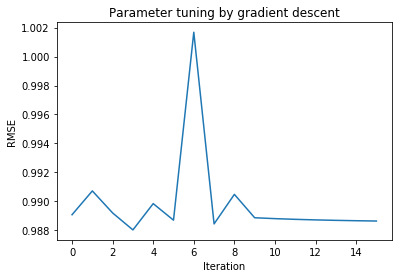

<Figure size 432x288 with 0 Axes>

In [41]:
plt.plot(min_rmse_te)
plt.title("Parameter tuning by gradient descent")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.savefig('../plots/RMSE_SGD_tuning_GD.png')
plt.show()

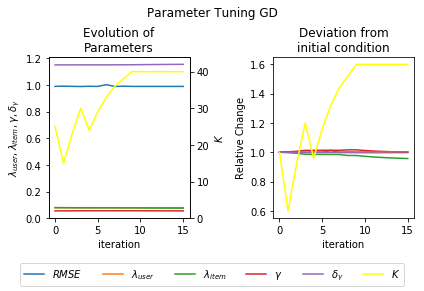

In [42]:
plot_gradient_descent_tuning_parameters_MF_SGD(num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size, 
                                                   min_rmse_te)
plt.savefig('../plots/Param_SGD_tuning_GD.png')

### Matrix factorization SGD baseline correction

#### "Item mean average user offset" - baseline

The "item mean average user offset" baseline was used. As initial condition the parameters yielding the best result in the previous trial and error tuning were taken.

In [ ]:
"""
pred_baseline_train = better_average_movie_ratings[train.row] + better_average_user_offsets[train.col]
pred_baseline_test = better_average_movie_ratings[test.row] + better_average_user_offsets[test.col]

train_baseline_corrected = sp.coo_matrix((train.data - pred_baseline_train, (train.row, train.col)), 
                                          shape=train.get_shape())
test_baseline_corrected = sp.coo_matrix((test.data - pred_baseline_test, (test.row, test.col)), 
                                         shape=test.get_shape())

seed = 988
stop_criterion = 0
lr = 0.005 # learning rate for gradient descent in the parameter space
dec_lr = 1.2 # decrement of the learning rate
dx = 0.0005 # stepsize for gradient approximation
max_iter = 10 # iterations of the global loop
num_epochs = 20 # epochs of SGD


# Initial values of parameters
num_features_init = 98   # K in the lecture notes
lambda_user_init = 0.17417125126472585
lambda_item_init = 0.022927141282293662
gamma_init = 0.05316983615800039
gamma_dec_step_size_init = 1.156493980121189

min_rmse_te, num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size = \
    gradient_descent_tuning_parameters_MF_SGD(train_baseline_corrected, test_baseline_corrected, num_features_init, 
                                              lambda_user_init, lambda_item_init, gamma_init, gamma_dec_step_size_init, 
                                              seed, stop_criterion, lr, dec_lr, dx, max_iter, num_epochs,True)
"""

In [43]:
# Save the result of long computations
num_features = np.array([98, 96, 103, 104, 105, 110, 106, 103, 106, 104, 104])

lambda_user = np.array([0.17417125126472585, 0.17355675194122716, 0.1735664935216406, 0.17090668983868207,
                        0.17006065227350167, 0.1700189172434683, 0.17001247393899743, 0.17001866795580695,
                        0.16996045099248142, 0.1699603158875205, 0.16935613928582255])

lambda_item = np.array([0.022927141282293662, 0.018456896384876367, 0.020531337831369584, 0.018491144039169977,
                        0.019799126670911004, 0.019782610052843572, 0.019849425921645358, 0.020048940664470875,
                        0.019889235280431905, 0.019989541989335318, 0.02047435434491142])

gamma = np.array([0.05316983615800039, 0.0548607159177026, 0.05384331602885772, 0.053276247404220003, 
                  0.05563698644757578, 0.055649509466532694, 0.05562269239245566, 0.0556542152960454, 
                  0.05574469631424865, 0.055764902993114075, 0.05634365815074227])

gamma_dec_step_size = np.array([1.156493980121189, 1.155925136424235, 1.1562321233865842, 1.1567463343781492,
                                1.156206175609709, 1.1562152819980447, 1.1562287142682113, 1.1562526610302777, 
                                1.1562409181355424, 1.1562494556131313, 1.1563126695382224])

min_rmse_te = np.array([0.9808699291069213, 0.9807433561955233, 0.98078743875507, 0.9808349224813601, 
                        0.9807745146671734, 0.9807368532260792, 0.9806704681225971, 0.9808078396326019, 
                        0.9806690929390709, 0.9807715912158108, 0.9807507915560066])


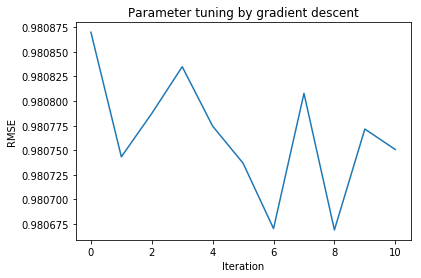

<Figure size 432x288 with 0 Axes>

In [44]:
plt.plot(min_rmse_te)
plt.title("Parameter tuning by gradient descent")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.savefig('../plots/RMSE_SGD_baseline_item_mean_user_offset_tuning_GD.png')
plt.show()

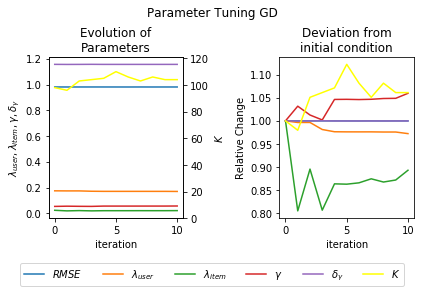

In [45]:
plot_gradient_descent_tuning_parameters_MF_SGD(num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size, 
                                                   min_rmse_te)
plt.savefig('../plots/Param_SGD_baseline_item_mean_user_offset_tuning_GD.png')

#### "Simple linear model" - baseline

As initial condition the parameters yielding the best result for the "item mean average user offset" baseline was used.

In [154]:
"""
train_baseline_corrected = sp.coo_matrix((train.data - w_item[train.row] - w_user[train.col] - w_0, 
                                         (train.row, train.col)), shape=train.get_shape())
test_baseline_corrected = sp.coo_matrix((test.data - w_item[test.row] - w_user[test.col] - w_0, (test.row, test.col)),
                                         shape=test.get_shape())

seed = 988
stop_criterion = 0
lr = 0.005 # learning rate for gradient descent in the parameter space
dec_lr = 1.2 # decrement of the learning rate
dx = 0.0005 # stepsize for gradient approximation
max_iter = 10 # iterations of the global loop
num_epochs = 20 # epochs of SGD


# Initial values of parameters
num_features_init = 106   # K in the lecture notes
lambda_user_init = 0.16996045099248142
lambda_item_init = 0.019889235280431905
gamma_init = 0.05574469631424865
gamma_dec_step_size_init = 1.1562409181355424

min_rmse_te, num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size = \
gradient_descent_tuning_parameters_MF_SGD(train_baseline_corrected, test_baseline_corrected, num_features_init, 
                                          lambda_user_init, lambda_item_init, gamma_init, gamma_dec_step_size_init, 
                                          seed, stop_criterion, lr, dec_lr, dx, max_iter, num_epochs,True)
"""

learn the matrix factorization using SGD...
initial RMSE on training set: 0.9891739647388105, RMSE on testing set: 1.0002491352457406.
iter: 0, RMSE on training set: 0.9891463272786434, RMSE on testing set: 1.0002459509786483.
iter: 1, RMSE on training set: 0.9889737582796252, RMSE on testing set: 1.0001645003504611.
iter: 2, RMSE on training set: 0.9866709179109332, RMSE on testing set: 0.9987962161591459.
iter: 3, RMSE on training set: 0.9771813663989641, RMSE on testing set: 0.9936182444472255.
iter: 4, RMSE on training set: 0.9672621997831734, RMSE on testing set: 0.9897483167825143.
iter: 5, RMSE on training set: 0.9575071551114039, RMSE on testing set: 0.986930156720803.
iter: 6, RMSE on training set: 0.9461039001000291, RMSE on testing set: 0.9845292071304981.
iter: 7, RMSE on training set: 0.933693874008737, RMSE on testing set: 0.9828563444556685.
iter: 8, RMSE on training set: 0.9208051130362889, RMSE on testing set: 0.981723462914779.
iter: 9, RMSE on training set: 0.9076882

iter: 5, RMSE on training set: 0.9578547637081026, RMSE on testing set: 0.986755791852263.
iter: 6, RMSE on training set: 0.9466060558914534, RMSE on testing set: 0.9845724013092149.
iter: 7, RMSE on training set: 0.9339142185562305, RMSE on testing set: 0.9827406207385779.
iter: 8, RMSE on training set: 0.920903536523258, RMSE on testing set: 0.9816658705143714.
iter: 9, RMSE on training set: 0.9078116179528185, RMSE on testing set: 0.98107123445177.
iter: 10, RMSE on training set: 0.8952579846473937, RMSE on testing set: 0.9808650446904458.
iter: 11, RMSE on training set: 0.8834890052617531, RMSE on testing set: 0.9809808792749999.
RMSE on test data: 0.9808650446904458.
it = (1/10), rmse = 0.9808650446904458, num_features = 96, lambda_user = 0.16990542380180632, lambda_item = 0.019670404816943713, gamma = 0.055810570983864084, dec_step_size = 1.156220256205453
learn the matrix factorization using SGD...
initial RMSE on training set: 0.989173914731626, RMSE on testing set: 1.000248630

iter: 9, RMSE on training set: 0.9068564310601229, RMSE on testing set: 0.9814234370257414.
iter: 10, RMSE on training set: 0.8939693191604839, RMSE on testing set: 0.9813904246765031.
iter: 11, RMSE on training set: 0.882014684900349, RMSE on testing set: 0.9815314236975999.
RMSE on test data: 0.9813904246765031.
it = (2/10), rmse = 0.9813904246765031, num_features = 88, lambda_user = 0.16980459938152695, lambda_item = 0.019290330970478074, gamma = 0.05591991945507473, dec_step_size = 1.1561779401236536
learn the matrix factorization using SGD...
initial RMSE on training set: 0.9891739200003825, RMSE on testing set: 1.0002487644521723.
iter: 0, RMSE on training set: 0.9891493247178651, RMSE on testing set: 1.0002458866041077.
iter: 1, RMSE on training set: 0.9889814564611208, RMSE on testing set: 1.0001672830701238.
iter: 2, RMSE on training set: 0.9865961461850911, RMSE on testing set: 0.9987542088188344.
iter: 3, RMSE on training set: 0.9769359140083526, RMSE on testing set: 0.99355

learn the matrix factorization using SGD...
initial RMSE on training set: 0.9891739092987247, RMSE on testing set: 1.0002487607337136.
iter: 0, RMSE on training set: 0.9891485165801186, RMSE on testing set: 1.000246037225732.
iter: 1, RMSE on training set: 0.9889847376687839, RMSE on testing set: 1.0001695705307292.
iter: 2, RMSE on training set: 0.9867546205993576, RMSE on testing set: 0.9988482284312296.
iter: 3, RMSE on training set: 0.9772040082285494, RMSE on testing set: 0.993638338482224.
iter: 4, RMSE on training set: 0.967433930342101, RMSE on testing set: 0.9896010602074423.
iter: 5, RMSE on training set: 0.9577472467051648, RMSE on testing set: 0.9867295434687282.
iter: 6, RMSE on training set: 0.9464442555759309, RMSE on testing set: 0.9845459992390984.
iter: 7, RMSE on training set: 0.9336940626899576, RMSE on testing set: 0.9827186108611715.
iter: 8, RMSE on training set: 0.9206225488923143, RMSE on testing set: 0.9816501630067973.
iter: 9, RMSE on training set: 0.9074715

iter: 3, RMSE on training set: 0.9767187058788882, RMSE on testing set: 0.9934829963545896.
iter: 4, RMSE on training set: 0.9671324687812553, RMSE on testing set: 0.9895872470148422.
iter: 5, RMSE on training set: 0.9569584701277425, RMSE on testing set: 0.986612810656962.
iter: 6, RMSE on training set: 0.9454434323826016, RMSE on testing set: 0.9844002005242435.
iter: 7, RMSE on training set: 0.9326988464126373, RMSE on testing set: 0.9826398979668242.
iter: 8, RMSE on training set: 0.9194639965912611, RMSE on testing set: 0.9817258860472402.
iter: 9, RMSE on training set: 0.9060855154358795, RMSE on testing set: 0.9812616314216192.
iter: 10, RMSE on training set: 0.8930628890989262, RMSE on testing set: 0.9811689064051452.
iter: 11, RMSE on training set: 0.8810442809603268, RMSE on testing set: 0.9813036040565836.
RMSE on test data: 0.9811689064051452.
learn the matrix factorization using SGD...
initial RMSE on training set: 0.9891739301433969, RMSE on testing set: 1.000248606772425

iter: 6, RMSE on training set: 0.9487051146012959, RMSE on testing set: 0.9848434530829621.
iter: 7, RMSE on training set: 0.9371390846462624, RMSE on testing set: 0.9830587799807574.
iter: 8, RMSE on training set: 0.925016691388334, RMSE on testing set: 0.982010853677945.
iter: 9, RMSE on training set: 0.9128714589052176, RMSE on testing set: 0.981381394661299.
iter: 10, RMSE on training set: 0.9011329908670116, RMSE on testing set: 0.98104111169186.
iter: 11, RMSE on training set: 0.8902404984027016, RMSE on testing set: 0.9810263468996842.
iter: 12, RMSE on training set: 0.8801894821247108, RMSE on testing set: 0.9812209270087245.
RMSE on test data: 0.9810263468996842.
learn the matrix factorization using SGD...
initial RMSE on training set: 0.9891739092987247, RMSE on testing set: 1.0002487607337136.
iter: 0, RMSE on training set: 0.9891494738844449, RMSE on testing set: 1.000246193601624.
iter: 1, RMSE on training set: 0.989001668410928, RMSE on testing set: 1.0001777821445943.
it

iter: 5, RMSE on training set: 0.9600863195973833, RMSE on testing set: 0.9873030703896901.
iter: 6, RMSE on training set: 0.9499072061162882, RMSE on testing set: 0.9849574925713281.
iter: 7, RMSE on training set: 0.9386082627630055, RMSE on testing set: 0.9831525634439869.
iter: 8, RMSE on training set: 0.9269787646174796, RMSE on testing set: 0.9820061939138086.
iter: 9, RMSE on training set: 0.9152704915665711, RMSE on testing set: 0.9813482612460813.
iter: 10, RMSE on training set: 0.9038328066171406, RMSE on testing set: 0.98101911181985.
iter: 11, RMSE on training set: 0.893142991671509, RMSE on testing set: 0.9809783844727448.
iter: 12, RMSE on training set: 0.8833312189887976, RMSE on testing set: 0.9810752316029934.
RMSE on test data: 0.9809783844727448.
learn the matrix factorization using SGD...
initial RMSE on training set: 0.9891739675296941, RMSE on testing set: 1.0002486808543558.
iter: 0, RMSE on training set: 0.9891511495650541, RMSE on testing set: 1.0002467172808005

iter: 4, RMSE on training set: 0.968951559822294, RMSE on testing set: 0.9901112117418516.
iter: 5, RMSE on training set: 0.9601194551604053, RMSE on testing set: 0.9873182555480139.
iter: 6, RMSE on training set: 0.950050492024228, RMSE on testing set: 0.9851614728692834.
iter: 7, RMSE on training set: 0.938620503809475, RMSE on testing set: 0.9832458289483684.
iter: 8, RMSE on training set: 0.9269258268942854, RMSE on testing set: 0.9820435671287391.
iter: 9, RMSE on training set: 0.9151301530163607, RMSE on testing set: 0.9812964473147526.
iter: 10, RMSE on training set: 0.9037520625759785, RMSE on testing set: 0.9809256800990188.
iter: 11, RMSE on training set: 0.8929803386077305, RMSE on testing set: 0.9808627524801553.
iter: 12, RMSE on training set: 0.8831610392328604, RMSE on testing set: 0.9809825106689883.
RMSE on test data: 0.9808627524801553.
learn the matrix factorization using SGD...
initial RMSE on training set: 0.9891739281950084, RMSE on testing set: 1.000248574770194.

iter: 2, RMSE on training set: 0.9870785812234284, RMSE on testing set: 0.9990366425205125.
iter: 3, RMSE on training set: 0.978698304429153, RMSE on testing set: 0.9944562189157579.
iter: 4, RMSE on training set: 0.969152882364219, RMSE on testing set: 0.9903562549152154.
iter: 5, RMSE on training set: 0.9601664688014676, RMSE on testing set: 0.9873912640088724.
iter: 6, RMSE on training set: 0.9497990019833095, RMSE on testing set: 0.9852092079066265.
iter: 7, RMSE on training set: 0.9385775338182893, RMSE on testing set: 0.9834253674782546.
iter: 8, RMSE on training set: 0.9267579464072394, RMSE on testing set: 0.9821585571078554.
iter: 9, RMSE on training set: 0.9147749592070304, RMSE on testing set: 0.9814616021808089.
iter: 10, RMSE on training set: 0.9030847458344112, RMSE on testing set: 0.9811173869001132.
iter: 11, RMSE on training set: 0.8921096702422567, RMSE on testing set: 0.9810990748900411.
iter: 12, RMSE on training set: 0.8820843228174394, RMSE on testing set: 0.98122

iter: 0, RMSE on training set: 0.9891499616879874, RMSE on testing set: 1.0002462628767423.
iter: 1, RMSE on training set: 0.9890091320441794, RMSE on testing set: 1.0001812469666864.
iter: 2, RMSE on training set: 0.9871763389482335, RMSE on testing set: 0.999092833210459.
iter: 3, RMSE on training set: 0.9785391409309082, RMSE on testing set: 0.9942726528444675.
iter: 4, RMSE on training set: 0.9690959149828909, RMSE on testing set: 0.9901615907424333.
iter: 5, RMSE on training set: 0.9603372879251396, RMSE on testing set: 0.9873747169177244.
iter: 6, RMSE on training set: 0.9503821295917905, RMSE on testing set: 0.985222552372396.
iter: 7, RMSE on training set: 0.9390736217249913, RMSE on testing set: 0.983300112187887.
iter: 8, RMSE on training set: 0.9275049515003418, RMSE on testing set: 0.9820860653018584.
iter: 9, RMSE on training set: 0.9158351190853866, RMSE on testing set: 0.9813249862665732.
iter: 10, RMSE on training set: 0.9045731741972844, RMSE on testing set: 0.98093907

In [46]:
# Save the result of long computations
num_features = np.array([106, 96, 88, 95, 101, 96, 92, 95, 98, 96, 96])

lambda_user = np.array([0.16996045099248142, 0.16990542380180632, 0.16980459938152695, 0.16983534225320215, 
                        0.16981974911644207, 0.16983147034201182, 0.16984644775626412, 0.1698532477222945, 
                        0.16985207911079422, 0.1698534010446083, 0.16973899409008433])

lambda_item = np.array([0.019889235280431905, 0.019670404816943713, 0.019290330970478074, 0.019646864521133834, 
                        0.019663196131643832, 0.020234698932132835, 0.02045834839300576, 0.02054392740171829, 
                        0.020581522131927456, 0.020631232619235364, 0.021592492982968833])

gamma = np.array([0.05574469631424865, 0.055810570983864084, 0.05591991945507473, 0.05582862025397367, 
                  0.05583543269633815, 0.05562276416402027, 0.05565798922169955, 0.05564041328226303, 
                  0.05563239428992951, 0.05561936186938201, 0.05559634513001232])

gamma_dec_step_size = np.array([1.1562409181355424, 1.156220256205453, 1.1561779401236536, 1.1562117689786489, 
                                1.156213207610708, 1.1562684797541467, 1.1562909306097382, 1.1562987329657188, 
                                1.15630181881718, 1.1563058680288183, 1.156343093162069])

min_rmse_te = np.array([0.980949155375984, 0.9808650446904458, 0.9813904246765031, 0.9811397807438909, 
                        0.9811235088893729, 0.9808844465483464, 0.9812869438919885, 0.9810854440097119, 
                        0.9809476236193987, 0.980859382689296, 0.9808596165066188])


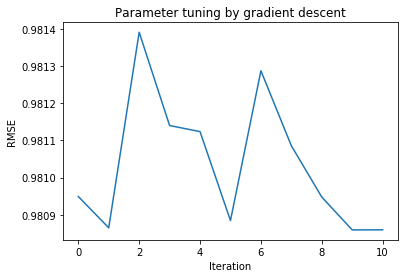

<Figure size 432x288 with 0 Axes>

In [47]:
plt.plot(min_rmse_te)
plt.title("Parameter tuning by gradient descent")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.savefig('../plots/RMSE_SGD_baseline_linear_tuning_GD.png')
plt.show()

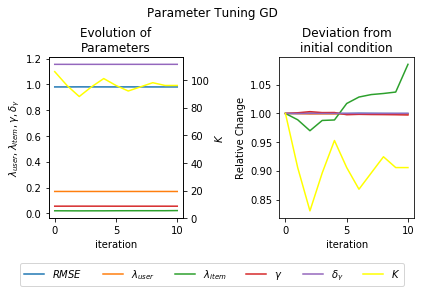

In [48]:
plot_gradient_descent_tuning_parameters_MF_SGD(num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size, 
                                                   min_rmse_te)
plt.savefig('../plots/Param_SGD_baseline_linear_tuning_GD.png')

ALS with the same parameters doesn't work well, since it converges too fast. The training error decreases too rapidly and the testing error, after an initial decrease strats to grow again without ever reaching a low level.

In [50]:
num_features = 106   # K in the lecture notes
lambda_user = 0.16996045099248142
lambda_item = 0.019889235280431905
stop_criterion = 0
max_iter = 5
seed = 988

train_baseline_pred = better_average_movie_ratings[train.row] + better_average_user_offsets[train.col]
test_baseline_pred = better_average_movie_ratings[test.row] + better_average_user_offsets[test.col]

train_baseline_corrected = sp.coo_matrix((train.data - train_baseline_pred, (train.row, train.col)), 
                                         shape=train.get_shape())
test_baseline_corrected = sp.coo_matrix((test.data - test_baseline_pred, (test.row, test.col)), 
                                        shape=test.get_shape())
min_rmse_te_ALS = ALS(train_baseline_corrected, test_baseline_corrected, num_features, lambda_user, lambda_item, 
                      max_iter, seed, stop_criterion, True)

initial: RMSE on training set: 0.9953396411311225, RMSE on testing set: 1.004107527266363.
iter: 0, RMSE on training set: 0.995179251489145, RMSE on testing set: 1.0041024111210026.
iter: 1, RMSE on training set: 0.9925463814578906, RMSE on testing set: 1.0037048099587236.
iter: 2, RMSE on training set: 0.9437659411470151, RMSE on testing set: 0.9922603597414608.
iter: 3, RMSE on training set: 0.8094993454134891, RMSE on testing set: 0.9899695138744148.
iter: 4, RMSE on training set: 0.7198013266716823, RMSE on testing set: 0.9996933029756501.
RMSE on test data: 0.9899695138744148.


# Matrix factorization SGD with introduced nonlinearity

When the predicted baseline errors are plotted against the actual ones, a bulky cloud appears instead of a clearcut line. This suggests that the linear model might not be enough to do the complex classification. In the following a non-linearity is introduced. A sigmoid function is applied to the result of the matrix factorization. This customized sigmoid function is chosen in such a fashion that the resulting values lie between one and five. The slope of the sigmoid must be accounted for when the gradient gets calculated. It is shifted so that sigma of zero gives the mean of the ratings in the training set.

In [51]:
shift = sigmoid_inv(np.mean(train.data))
assert(sigmoid_customized(0,shift) == np.mean(train.data))

The best error was obtained with the following parameters after a trial and error search. It does not even come close to the prdictions obtained with the simpler linear model.

In [54]:
num_features = 50   # K in the lecture notes
lambda_user = 0.3
lambda_item = 0.01
stop_criterion = 0
max_iter = 10
num_epochs = 30
seed = 988

gamma = 0.05
gamma_dec_step_size = 1.25


min_rmse_te_SGD_sigmoid, user_features_SGD_sigmoid, item_features_SGD_sigmoid = \
    matrix_factorization_SGD_regularized_sigmoid_predict(train, test, num_features, lambda_user, lambda_item,
                                                         gamma, gamma_dec_step_size, num_epochs, seed, 
                                                         stop_criterion, shift)

learn the matrix factorization using SGD...
initial RMSE on training set: 1.1193039250209036, RMSE on testing set: 1.1167842964651549.
iter: 0, RMSE on training set: 1.119268157133522, RMSE on testing set: 1.1167548342592812.
iter: 1, RMSE on training set: 1.1041665782778183, RMSE on testing set: 1.102972752293121.
iter: 2, RMSE on training set: 1.053699245990307, RMSE on testing set: 1.0632428641481715.
iter: 3, RMSE on training set: 1.0560826772556076, RMSE on testing set: 1.067500447388873.
iter: 4, RMSE on training set: 1.0558315024795888, RMSE on testing set: 1.067249276158706.
iter: 5, RMSE on training set: 1.054954799757676, RMSE on testing set: 1.0668928817138768.
iter: 6, RMSE on training set: 1.0528246001342296, RMSE on testing set: 1.064838877662327.
iter: 7, RMSE on training set: 1.0505056597586884, RMSE on testing set: 1.0627619943438031.
iter: 8, RMSE on training set: 1.0475783243011758, RMSE on testing set: 1.0604401399494479.
iter: 9, RMSE on training set: 1.04472758958

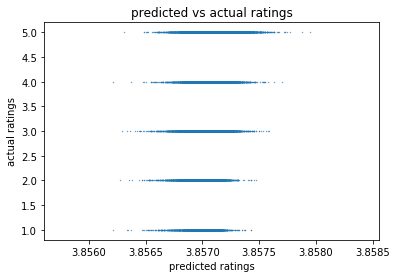

In [53]:
# Plot prediction versus test values
plt.title("predicted vs actual ratings")
plt.xlabel("predicted ratings")
plt.ylabel("actual ratings")
plt.scatter(sigmoid_customized(np.dot(item_features_SGD_sigmoid.T,user_features_SGD_sigmoid)[test.nonzero()],shift),
            test.data,s=0.1)
plt.savefig('../plots/sigmoid_pred.png')

In this case, even ptimizing parameters by gradient descent is computationally too costly. The code is provided bellow.

In [377]:
"""
seed = 988
stop_criterion = 0
lr = 0.005 # learning rate for gradient descent in the parameter space
dec_lr = 1.2 # decrement of the learning rate
dx = 0.0005 # stepsize for gradient approximation
max_iter = 10 # iterations of the global loop
num_epochs = 20 # epochs of SGD


# Initial values of parameters
num_features_init = 100   # K in the lecture notes
lambda_user_init = 0.3
lambda_item_init = 0.01
gamma_init = 0.05
gamma_dec_step_size_init = 1.25

min_rmse_te, num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size = \
    gradient_descent_tuning_parameters_MF_SGD_sigmoid(train, test, num_features_init, lambda_user_init, 
                                                      lambda_item_init, gamma_init, gamma_dec_step_size_init, 
                                                      seed, stop_criterion, lr, dec_lr, dx, max_iter, num_epochs)
"""

learn the matrix factorization using SGD...
initial RMSE on training set: 1.1651847553221253, RMSE on testing set: 1.161105901218834.
iter: 0, RMSE on training set: 1.1101645231922308, RMSE on testing set: 1.1395889415576514.
iter: 1, RMSE on training set: 1.0740332633605105, RMSE on testing set: 1.1177499748109085.
iter: 2, RMSE on training set: 1.0138195268514187, RMSE on testing set: 1.0836999508596254.
iter: 3, RMSE on training set: 0.9680942412054245, RMSE on testing set: 1.06432033641065.
iter: 4, RMSE on training set: 0.9234140019697081, RMSE on testing set: 1.0466652173579825.
iter: 5, RMSE on training set: 0.8875108893875356, RMSE on testing set: 1.02893008701221.
iter: 6, RMSE on training set: 0.8593727531235235, RMSE on testing set: 1.0203994460881547.
iter: 7, RMSE on training set: 0.8344015468260159, RMSE on testing set: 1.010614402210568.
iter: 8, RMSE on training set: 0.8186512640520613, RMSE on testing set: 1.0074449114875978.
iter: 9, RMSE on training set: 0.8047671102

iter: 1, RMSE on training set: 1.0539324640750694, RMSE on testing set: 1.065231116692838.
iter: 2, RMSE on training set: 1.0509366645285367, RMSE on testing set: 1.0640050805776813.
iter: 3, RMSE on training set: 1.0392903023553144, RMSE on testing set: 1.0540545373266452.
iter: 4, RMSE on training set: 1.0302117929204204, RMSE on testing set: 1.047157420829934.
iter: 5, RMSE on training set: 1.0256828101630802, RMSE on testing set: 1.044075241666898.
iter: 6, RMSE on training set: 1.023332766026165, RMSE on testing set: 1.0420059131168913.
iter: 7, RMSE on training set: 1.0217053716145232, RMSE on testing set: 1.0405554099092462.
iter: 8, RMSE on training set: 1.021047674210098, RMSE on testing set: 1.0404575328380221.
iter: 9, RMSE on training set: 1.020393382511628, RMSE on testing set: 1.040018071124295.
iter: 10, RMSE on training set: 1.019900103496989, RMSE on testing set: 1.0396871324898251.
iter: 11, RMSE on training set: 1.0195072175253135, RMSE on testing set: 1.039468448372

KeyboardInterrupt: 

# Estimate of variance

Last but not least, an estimate of the variance of the different methods is computed. The tuned models that yielded the lowest errors are compared.

In [55]:
#Initializing parameters

seeds = np.arange(1000,1010)
#seeds = np.arange(1000,1001)
stop_criterion = 0


# baselines
RMSE_global_mean = np.zeros(len(seeds))
RMSE_user_mean = np.zeros(len(seeds))
RMSE_item_mean = np.zeros(len(seeds))
RMSE_baseline_blending = np.zeros(len(seeds))
RMSE_baseline_linear = np.zeros(len(seeds))

# SGD MF
num_features_grid_SGD = 25   # K in the lecture notes
lambda_user_grid_SGD = 0.08
lambda_item_grid_SGD = 0.08
decrement_step_grid_SGD = 0.056
gamma_grid_SGD = 1.15
num_epochs_grid_SGD = 30
    
RMSE_SGD_grid_search_gamma = np.zeros(len(seeds))

num_features_SGD_GD = 30   # K in the lecture notes
lambda_user_SGD_GD = 0.07981220705248203
lambda_item_SGD_GD = 0.0788480708732502
decrement_step_SGD_GD = 1.1504010887632399
gamma_SGD_GD = 0.05671624697965875
num_epochs_SGD_GD = 30

RMSE_SGD_GD = np.zeros(len(seeds))

# ALS
num_features_ALS = 25
lambda_item_ALS = 0.01
lambda_user_ALS = 1.0
max_iter = 10

RMSE_ALS_grid_search = np.zeros(len(seeds))

# SGD baseline

num_features_blending = 106   # K in the lecture notes
lambda_user_blending = 0.16996045099248142
lambda_item_blending = 0.019889235280431905
num_epochs_blending = 20
gamma_blending = 0.05574469631424865
decrement_step_blending = 1.1562409181355424

RMSE_SGD_baseline_blending_GD = np.zeros(len(seeds))

num_features_linear = 96   # K in the lecture notes
lambda_user_linear = 0.1698534010446083
lambda_item_linear = 0.020631232619235364
num_epochs_linear = 20
gamma_linear = 0.05561936186938201
decrement_step_linear = 1.1563058680288183

RMSE_SGD_baseline_linear_GD = np.zeros(len(seeds))

# sigmoid
num_features_sigmoid = 50   # K in the lecture notes
lambda_user_sigmoid = 0.3
lambda_item_sigmoid = 0.01
num_epochs_sigmoid = 15
gamma_sigmoid = 0.05
decrement_step_sigmoid = 1.25

RMSE_SGD_sigmoid = np.zeros(len(seeds))

In [58]:
"""
# Compute RMSE of different models with different splits
for ind_seed, seed in enumerate(seeds):
    valid_ratings_, train_, test_ = split_data(ratings, num_items_per_user, num_users_per_item, 10,
                                            0.1,seed)
    
    RMSE_global_mean[ind_seed] = baseline_global_mean(train_, test_)
    RMSE_user_mean[ind_seed] = baseline_user_mean(train_, test_)
    RMSE_item_mean_, mean_rating_user = baseline_item_mean(train, test)
    RMSE_item_mean[ind_seed] = RMSE_item_mean_
    
    RMSE_blending, better_average_movie_ratings_, better_average_user_offsets_ = baseline_average_item_user_offset(
                                                                                                train_, test_, 25, 25)
    RMSE_baseline_blending[ind_seed] = RMSE_blending
    
    RMSE_linear, w_item_, w_user_, w_0_ = baseline_item_user(train_, test_)
    RMSE_baseline_linear[ind_seed] = RMSE_linear
    
    pred_blending_train = better_average_movie_ratings_[train_.row] + better_average_user_offsets_[train_.col]
    pred_blending_test = better_average_movie_ratings_[test_.row] + better_average_user_offsets_[test_.col]
    
    train_baseline_corrected = sp.coo_matrix((train_.data - pred_blending_train, (train_.row, train_.col)),
                                             shape=train_.get_shape())
    test_baseline_corrected = sp.coo_matrix((test_.data - pred_blending_test, (test_.row, test_.col)),
                                            shape=test_.get_shape())

    RMSE_SGD_baseline_blending_GD[ind_seed] = matrix_factorization_SGD_regularized(train_baseline_corrected,
                                                                         test_baseline_corrected,
                                                                         num_features_blending,
                                                                         lambda_user_blending, lambda_item_blending,
                                                                         gamma_blending, decrement_step_blending,
                                                                         num_epochs_blending, seed, stop_criterion,True)
    
    pred_linear_train = w_item_[train_.row] + w_user_[train_.col] + w_0_
    pred_linear_test = w_item_[test_.row] + w_user_[test_.col] + w_0_
    train_baseline_corrected = sp.coo_matrix((train_.data - pred_linear_train, (train_.row, train_.col)), 
                                             shape=train.get_shape())
    test_baseline_corrected = sp.coo_matrix((test_.data - pred_linear_test, (test_.row, test_.col)), 
                                            shape=test.get_shape())

    RMSE_SGD_baseline_linear_GD[ind_seed] = matrix_factorization_SGD_regularized(train_baseline_corrected,
                                                                       test_baseline_corrected, num_features_linear,
                                                                       lambda_user_linear, lambda_item_linear,
                                                                       gamma_linear, decrement_step_linear,
                                                                       num_epochs_linear, seed, stop_criterion,True)
    
    RMSE_sigmoid, uf_sigmoid, if_sigmoid = matrix_factorization_SGD_regularized_sigmoid_predict(
        train_, test_, num_features_sigmoid, lambda_user_sigmoid, lambda_item_sigmoid, gamma_sigmoid, 
        decrement_step_sigmoid, num_epochs_sigmoid, seed, stop_criterion,shift)
    RMSE_SGD_sigmoid[ind_seed] = RMSE_sigmoid
    
    RMSE_SGD_grid_search_gamma[ind_seed] = matrix_factorization_SGD_regularized(train_, test_, num_features_grid_SGD, 
                                                                                lambda_user_grid_SGD, 
                                                                                lambda_item_grid_SGD, 
                                                                                gamma_grid_SGD, decrement_step_grid_SGD,
                                                                                num_epochs_grid_SGD, seed, 
                                                                                stop_criterion,False)
    RMSE_SGD_GD[ind_seed] = matrix_factorization_SGD_regularized(train_, test_, num_features_SGD_GD, lambda_user_SGD_GD, 
                                                                 lambda_item_SGD_GD, gamma_SGD_GD, decrement_step_SGD_GD,
                                                                 num_epochs_SGD_GD, seed, stop_criterion,False)
    RMSE_ALS_grid_search[ind_seed] = ALS(train_, test_, num_features_ALS, lambda_user_ALS, lambda_item_ALS, max_iter,
                                         seed,False)
# Save data to file
RMSEs = np.vstack((RMSE_global_mean,RMSE_user_mean,RMSE_item_mean,RMSE_baseline_blending,RMSE_baseline_linear, 
                   RMSE_SGD_grid_search_gamma, RMSE_SGD_GD, RMSE_ALS_grid_search, RMSE_SGD_baseline_blending_GD,
                   RMSE_SGD_baseline_linear_GD,RMSE_SGD_sigmoid))
np.save('../results_of_lengthy_computations/RMSEs_cross_validation',RMSEs)
"""

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1059186
Total number of nonzero elements in test data:117687


KeyboardInterrupt: 

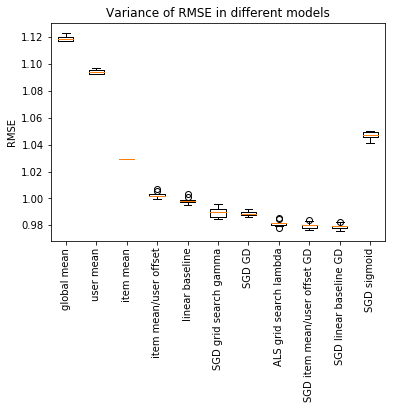

In [65]:
RMSEs = np.load('../results_of_lengthy_computations/RMSEs_cross_validation.npy')

plt.boxplot(RMSEs.T)
plt.title("Variance of RMSE in different models")
locs, labels = plt.xticks()
plt.xticks(locs, ('global mean', 'user mean', 'item mean', 'item mean/user offset', 'linear baseline',
                  'SGD grid search gamma','SGD GD','ALS grid search lambda','SGD item mean/user offset GD',
                  'SGD linear baseline GD','SGD sigmoid'),rotation=90)
plt.ylabel('RMSE')


plt.savefig('../plots/cross_validation.png')
plt.show()

# Generate Prediction

In [57]:
# Define the best parameters found above

num_features = 106   # K in the lecture notes
lambda_user = 0.16996045099248142
lambda_item = 0.019889235280431905
stop_criterion = 0
max_iter = 10
num_epochs = 20
seed = 988

gamma = 0.05574469631424865
gamma_dec_step_size = 1.1562409181355424

rmse_average_item_user_offset, better_average_movie_ratings, better_average_user_offsets = baseline_average_item_user_offset(train, test,25,100)

train_baseline_pred = better_average_movie_ratings[train.row] + better_average_user_offsets[train.col]
test_baseline_pred = better_average_movie_ratings[test.row] + better_average_user_offsets[test.col]

train_baseline_corrected = sp.coo_matrix((train.data - train_baseline_pred, (train.row, train.col)), 
                                         shape=train.get_shape())
test_baseline_corrected = sp.coo_matrix((test.data - test_baseline_pred, (test.row, test.col)), shape=test.get_shape())

min_rmse_te_SGD_bc, user_features_SGD_bc, item_features_SGD_bc = \
    matrix_factorization_SGD_regularized_predict(train_baseline_corrected, test_baseline_corrected, 
                                                 num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size, 
                                                 num_epochs, seed, stop_criterion,True)

learn the matrix factorization using SGD...
initial RMSE on training set: 0.9955924211586205, RMSE on testing set: 1.0040800582504035.
iter: 0, RMSE on training set: 0.9955608433909153, RMSE on testing set: 1.0040740205382541.
iter: 1, RMSE on training set: 0.9950807045731722, RMSE on testing set: 1.0037549470094105.
iter: 2, RMSE on training set: 0.9879886931586267, RMSE on testing set: 0.9989676416575408.
iter: 3, RMSE on training set: 0.9775106418047619, RMSE on testing set: 0.9932660883735267.
iter: 4, RMSE on training set: 0.9684480939494337, RMSE on testing set: 0.9901454967028804.
iter: 5, RMSE on training set: 0.9583146592931535, RMSE on testing set: 0.9872388359338757.
iter: 6, RMSE on training set: 0.9462268357138949, RMSE on testing set: 0.9847770893519388.
iter: 7, RMSE on training set: 0.9334980131539448, RMSE on testing set: 0.9831569144118001.
iter: 8, RMSE on training set: 0.9204769914396973, RMSE on testing set: 0.9821329731613674.
iter: 9, RMSE on training set: 0.9072

In [28]:
compute_error(test_baseline_corrected.data, user_features_SGD_bc, item_features_SGD_bc, 
              (test_baseline_corrected.row,test_baseline_corrected.col))

0.9807497327286656

In [58]:
prediction = compute_prediction_baseline_average_item_user_offset(ratings, valid_ratings.shape, item_features_SGD_bc,
                                                         user_features_SGD_bc, num_items_per_user,
                                                         num_users_per_item, 10, 
                                                         better_average_movie_ratings, better_average_user_offsets)

In [59]:
prediction[0:10,0:10]

array([[4., 3., 3., 4., 3., 4., 3., 3., 4., 3.],
       [4., 4., 4., 4., 4., 4., 4., 4., 3., 4.],
       [4., 3., 3., 4., 3., 4., 3., 4., 4., 3.],
       [4., 4., 3., 4., 4., 4., 4., 4., 4., 3.],
       [4., 3., 3., 4., 3., 4., 4., 4., 4., 3.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [4., 3., 3., 4., 3., 4., 4., 4., 4., 3.],
       [4., 4., 4., 3., 3., 4., 4., 4., 4., 4.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [4., 3., 4., 3., 4., 4., 4., 4., 4., 3.]])

In [60]:
prediction_discretized = np.rint(prediction)

# Output

In [61]:
DATA_SAMPLE_SUBMISSION_PATH = '../Datasets/sample_submission.csv'
ratings_submission_csv = load_data(DATA_SAMPLE_SUBMISSION_PATH)
rows_submission,cols_submission = ratings_submission_csv.tocoo().nonzero()
ids_test = ['r' + str(ind_col+1) + '_c' + str(ind_row+1) for ind_row, ind_col in zip(rows_submission,cols_submission)]

number of items: 1000, number of users: 10000


In [62]:
OUTPUT_PATH = '../Datasets/sample_submission_5.csv'
pred_submission = prediction_discretized[rows_submission,cols_submission].astype('int')
create_csv_submission(ids_test, pred_submission, OUTPUT_PATH)